In [1]:
%cd ..

/pub/hofmann-scratch/glanzillo/ded


In [2]:

import importlib
import json
import math
import os
import socket
import sys
import time


internal_path = os.path.abspath(os.path.join('.'))
sys.path.append(internal_path)
sys.path.append(internal_path + '/datasets')
sys.path.append(internal_path + '/utils')

import datetime
import uuid
from argparse import ArgumentParser

import setproctitle
import torch
import numpy as np
import pandas as pd 
import json


import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import AutoMinorLocator
from matplotlib.collections import LineCollection



/local/home/glanzillo/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
%ls

__init__.py  datasets/  requirements.txt  utils/
data/        logs/      scripts/          wandb/


In [142]:
logs_path = './logs/results/cifar5m/mnet/logs.txt'
results = []
with open(logs_path) as f:
    while line := f.readline():
        results.append(json.loads(line))

In [170]:
res_df = pd.DataFrame(results)
res_df

distributed   lr  checkpoints  pretrained  optim_wd  optim_adam   
0            no  0.1         True       False     0.001       False  \
1            no  0.1         True       False     0.001       False   
2            no  0.1         True       False     0.001       False   
3            no  0.1         True       False     0.001       False   
4            no  0.1         True       False     0.001       False   
..          ...  ...          ...         ...       ...         ...   
157          no  0.1         True       False     0.001       False   
158          no  0.1         True       False     0.001       False   
159          no  0.1         True       False     0.001       False   
160          no  0.1         True       False     0.001       False   
161          no  0.1         True       False     0.001       False   

     optim_mom  optim_warmup  optim_nesterov  optim_cosineanneal  ...  gamma   
0            0             5           False                True  ...    1.0  \
1            0             5           False                True  ...    1.0   
2            0             5           False                True  ...    1.0   
3            0             5           False                True  ...    1.0   
4            0             5           False                True  ...    1.0   
..         ...           ...             ...                 ...  ...    ...   
157          0             5           False                True  ...    1.0   
158          0             5           False                True  ...    1.0   
159          0             5           False                True  ...    1.0   
160          0             5           False                True  ...    1.0   
161          0             5           False                True  ...    1.0   

     final_val_acc_D  buffer_train_time  final_train_acc_S final_val_acc_S   
0              78.18        1194.966549          90.303333           82.04  \
1              73.84         846.080246          75.695000           71.77   
2              73.84         844.939077          91.461667           76.98   
3              73.84         855.691574          76.206667           71.53   
4              73.84         865.116743          76.753333           71.91   
..               ...                ...                ...             ...   
157            65.91         829.776754          91.293333           76.95   
158            65.91         832.049154          76.591667           70.14   
159            65.91         846.229966          77.440000           69.99   
160            65.91         842.355591          76.665000           69.87   
161            65.91         855.572142          91.245000           76.76   

     final_train_agreement final_val_agreement  final_val_function_distance   
0                83.103333               79.19                     0.224213  \
1                87.058333               84.44                     0.137418   
2                77.181667               72.47                     0.301173   
3                87.015000               84.57                     0.134699   
4                87.883333               85.09                     0.132162   
..                     ...                 ...                          ...   
157              74.368333               67.79                     0.310329   
158              82.703333               77.46                     0.211352   
159              82.960000               77.14                     0.212640   
160              82.863333               77.21                     0.213182   
161              74.745000               68.42                     0.305711   

     final_distance_teacher_student  recurrence_level  
0                         99.827530               NaN  
1                         92.841354               NaN  
2                         92.903893               NaN  
3                         92.821602               NaN  
4                       

In [171]:
res_df.columns

Index(['distributed', 'lr', 'checkpoints', 'pretrained', 'optim_wd',
       'optim_adam', 'optim_mom', 'optim_warmup', 'optim_nesterov',
       'optim_cosineanneal', 'n_epochs', 'n_epochs_stud', 'batch_size',
       'validate_subset', 'gpus_id', 'seed', 'notes', 'non_verbose',
       'disable_log', 'validation', 'ignore_other_metrics', 'debug_mode',
       'nowand', 'wandb_entity', 'wandb_project', 'wandb_name', 'buffer_size',
       'minibatch_size', 'alpha', 'MSE', 'distillation_type', 'K', 'N_BLOCKS',
       'gamma', 'final_val_acc_D', 'buffer_train_time', 'final_train_acc_S',
       'final_val_acc_S', 'final_train_agreement', 'final_val_agreement',
       'final_val_function_distance', 'final_distance_teacher_student',
       'recurrence_level'],
      dtype='object')

In [172]:
buffer_sizes = sorted(list(res_df['buffer_size'].unique()))
buffer_sizes

[600, 1200, 6000, 12000, 24000, 60000, 120000, 600000, 1200000]

In [173]:
res_df['buffer_size_p'] = res_df['buffer_size']/60000
res_df['generalization_gap'] = res_df['final_val_acc_S']-res_df['final_train_acc_S']
res_df['final_val_acc_S_p'] = 100*res_df['final_val_acc_S']/(teacher_val_accuracy)
res_df['final_train_acc_S_p'] = 100*res_df['final_train_acc_S']/(teacher_val_accuracy)
working_df = res_df.loc[res_df['final_val_acc_D']==80.38]
working_df = working_df.loc[working_df['recurrence_level'].isna()]
working_df = working_df.loc[working_df['MSE'].isin([np.nan, False]),:] # removing all the runs that didn't work 
working_df

distributed   lr  checkpoints  pretrained  optim_wd  optim_adam   
9            no  0.1         True       False     0.001       False  \
10           no  0.1         True       False     0.001       False   
11           no  0.1         True       False     0.001       False   
12           no  0.1         True       False     0.001       False   
13           no  0.1         True       False     0.001       False   
..          ...  ...          ...         ...       ...         ...   
96           no  0.1         True       False     0.001       False   
97           no  0.1         True       False     0.001       False   
98           no  0.1         True       False     0.001       False   
99           no  0.1         True       False     0.001       False   
100          no  0.1         True       False     0.001       False   

     optim_mom  optim_warmup  optim_nesterov  optim_cosineanneal  ...   
9            0             5           False                True  ...  \
10           0             5           False                True  ...   
11           0             5           False                True  ...   
12           0             5           False                True  ...   
13           0             5           False                True  ...   
..         ...           ...             ...                 ...  ...   
96           0             5           False                True  ...   
97           0             5           False                True  ...   
98           0             5           False                True  ...   
99           0             5           False                True  ...   
100          0             5           False                True  ...   

     final_val_acc_S  final_train_agreement  final_val_agreement   
9              79.44              88.063333                84.41  \
10             79.54              88.260000                84.10   
11             79.38              88.188333                84.36   
12             77.14              83.101667                76.05   
13             76.33              83.056667                76.36   
..               ...                    ...                  ...   
96             75.79              87.391667                79.60   
97             75.93              87.095833                79.90   
98             65.91              81.241667                66.33   
99             66.42              81.575000                66.70   
100            66.69              81.487500                67.87   

     final_val_function_distance final_distance_teacher_student   
9                       0.167789                      92.067696  \
10                      0.167323                      92.183929   
11                      0.165912                      92.082825   
12                      0.256830                      89.643623   
13                      0.257118                      89.576874   
..                           ...                            ...   
96                      0.214165                     135.085800   
97                      0.211925                     134.979660   
98                      0.341851                     133.546890   
99                      0.339940                     133.632889   
100                     0.332657                     133.715759   

     recurrence_level buffer_size_p  generalization_gap  final_val_acc_S_p   
9                 NaN           1.0           -3.878333         120.527993  \
10                NaN           1.0           -4.078333         120.679715   
11                NaN           1.0           -3.745000         120.436959   
12                NaN           1.0          -14.536667         117.038386   
13                NaN           1.0          -15.215000         115.809437   
..                ...           ...                 ...                ...   
96                NaN           0.4           -6.805833         114.990138   
97                NaN       

In [174]:
teacher_val_accuracy = list(working_df['final_val_acc_D'])[0]
#teacher_train_accuracy = 77.50
teacher_val_accuracy

80.38

In [197]:
buffer_sizes_p = sorted(working_df['buffer_size_p'].unique())
buffer_sizes_p

[0.01, 0.02, 0.1, 0.2, 0.4, 1.0, 2.0, 10.0, 20.0]

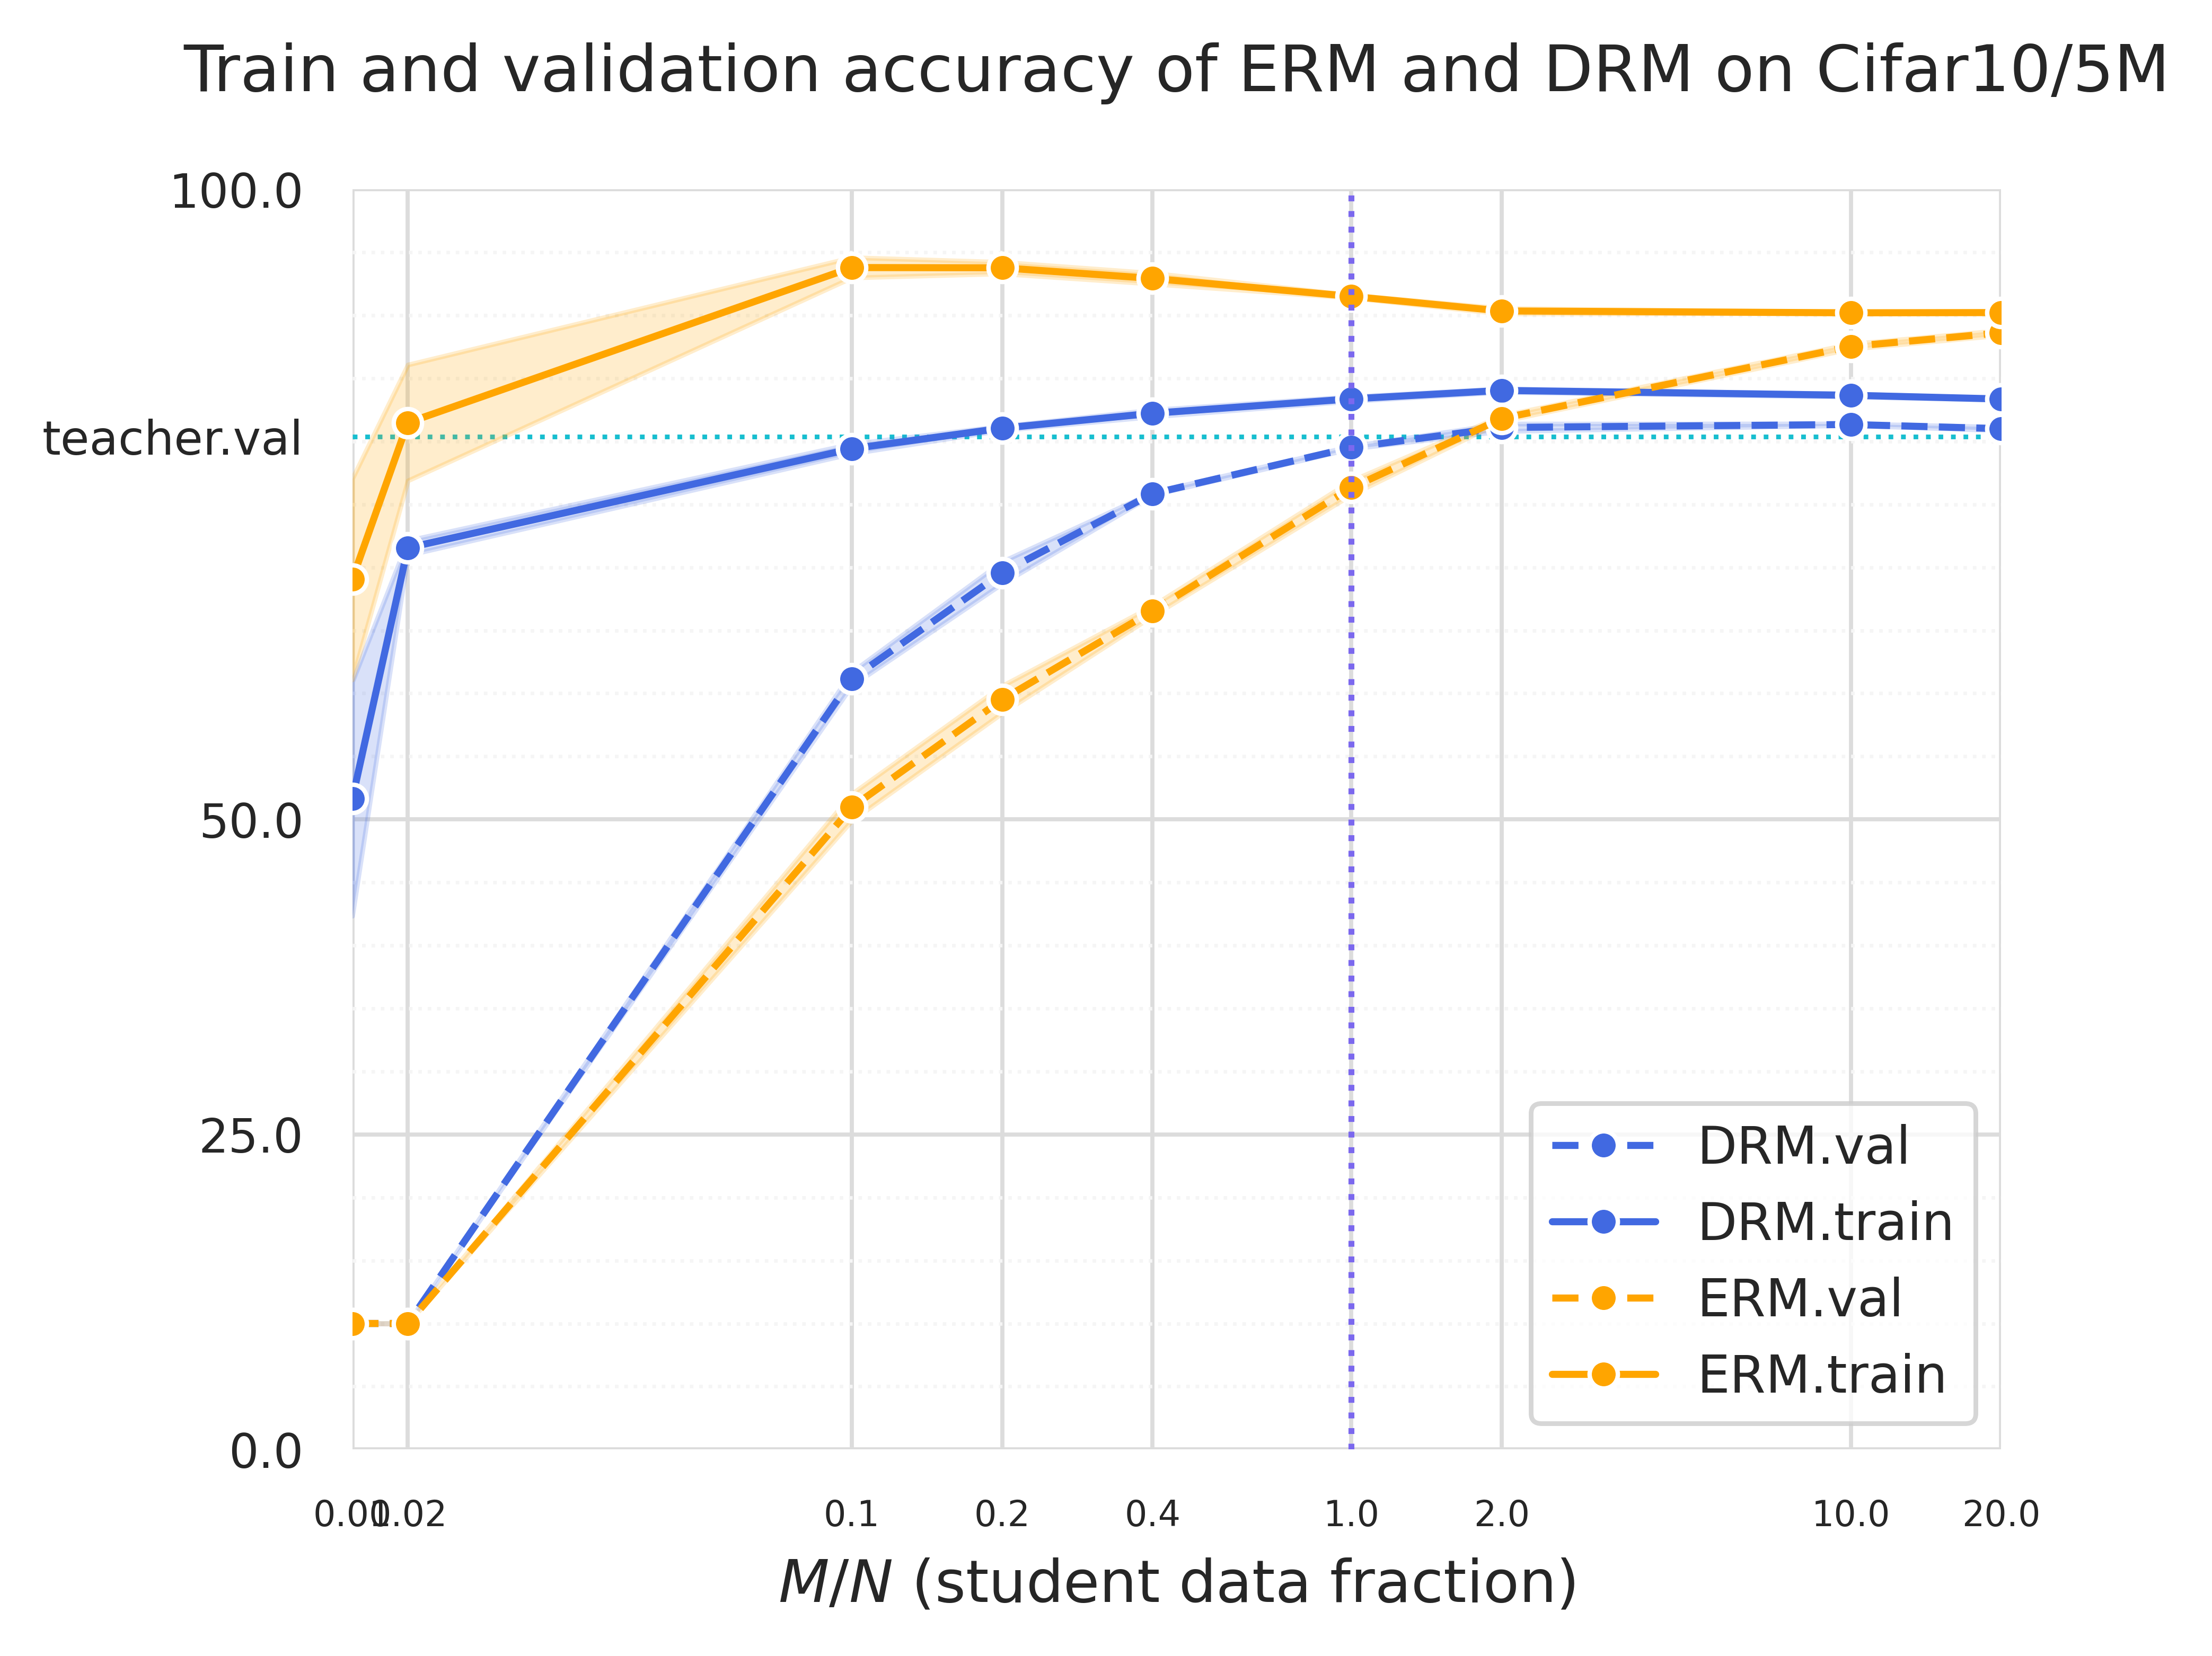

In [176]:
%matplotlib inline
sns.set_context("paper")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(5,4), sharey=True, dpi=800)
    colors = ['royalblue','orange','dimgray']


    _df = working_df.loc[working_df['alpha']==0.0]
    sns.lineplot(data=_df, x="buffer_size_p", y="final_val_acc_S", errorbar="sd",
                 markers=True, marker='o', color=colors[0], ls='--',ax=ax, label="distil.val")
    sns.lineplot(data=_df, x="buffer_size_p", y="final_train_acc_S", errorbar="sd",
                 markers=True, marker='o', color=colors[0], ls='-', ax=ax, label="distil.train")
    _df = working_df.loc[working_df['alpha']==1.0]
    sns.lineplot(data=_df, x="buffer_size_p", y="final_val_acc_S", errorbar="sd",
                markers=True, marker='o', color=colors[1], ls='--', ax=ax, label="labels.val")
    sns.lineplot(data=_df, x="buffer_size_p", y="final_train_acc_S", errorbar="sd",
                markers=True, marker='o', color=colors[1], ls='-', ax=ax, label="labels.train")
    

    #ax.axvline(100.0, ls='--', color='tab:green')
    # ax.axhline(76.034, ls='--', color=colors[2], label="a")
    # ax.axhline(teacher_train_accuracy, ls='-', color=colors[2], label="b")
    # # props = dict(boxstyle='square', facecolor='white', alpha=0.5)
    # ax.text(0.01, 0.9, 'teacher.val', transform=ax.transAxes, 
    #            fontsize=10, verticalalignment='top', bbox=props)
    #ax.set_xscale('log')
    ax.set_xscale('symlog',linthresh=10e-2)
    ax.set_xlim([0.1,0.4])
    ax.set_ylim([0.0,100.0])

    ax.tick_params(axis='both',  labelsize=9)
    ax.set_xticks(buffer_sizes_p)
    ax.set_xticklabels([ f'{l}' for l in buffer_sizes_p], fontsize=6)
    ax.tick_params(axis='x',  rotation=0)

    yticks = [0.0, 25.0, 50.0, teacher_val_accuracy, 100.0]
    plt.yticks(yticks)
    ax.set_yticklabels([0.0, 25.0, 50.0, 'teacher.val', 100.0], fontsize=8)

    ax.axvline(x=1.0, color='mediumslateblue', linewidth=1.0, linestyle=':')

    # #ax.text(10.0,0, "Local", color="white", bbox={'facecolor': 'tab:green', 'alpha': 0.5, 'pad': 10})
    # ax.set_ylim(-1,10000.0)


    ax.set_title(f"Train and validation accuracy of ERM and DRM on Cifar10/5M", fontsize=11, y=1.05)
    ax.set_ylabel(r'', fontsize=11, x=-0.2)
    ax.set_xlabel(r'$M/N$ (student data fraction)', fontsize=10, y=+1)


    #ax[t].legend(title="Eigen-index", loc="upper left")
    # Shrink current axis's height by 10% on the bottom
    
    h, _ = ax.get_legend_handles_labels()
    ax.legend(h, ['DRM.val','DRM.train',
                  'ERM.val','ERM.train',
                  'teacher.val','teacher.train'], 
                title="", ncol=1, loc="lower right")


    # AESTHETICS control 
    ax.set_facecolor('white')
    [ax.spines[side].set_visible(False) for side in ax.spines]
    # major and minor grids
    ax.grid(which='major', color='gainsboro', linewidth=0.7)
    ax.grid(which='minor', color='whitesmoke', linestyle=':', linewidth=0.6)
    # Make the minor ticks and gridlines show.
    ax.minorticks_on()
    #ax.tick_params(which='minor', bottom=False, left=False)
    #fig.supxlabel(r' % of dataset used', fontsize=12, y=-0.1)

    a = ax.get_ygridlines()
    b = a[3]
    b.set_color('tab:cyan')
    b.set_linewidth(0.8)
    b.set_linestyle(':')
    #sns.despine()
    plt.tight_layout()


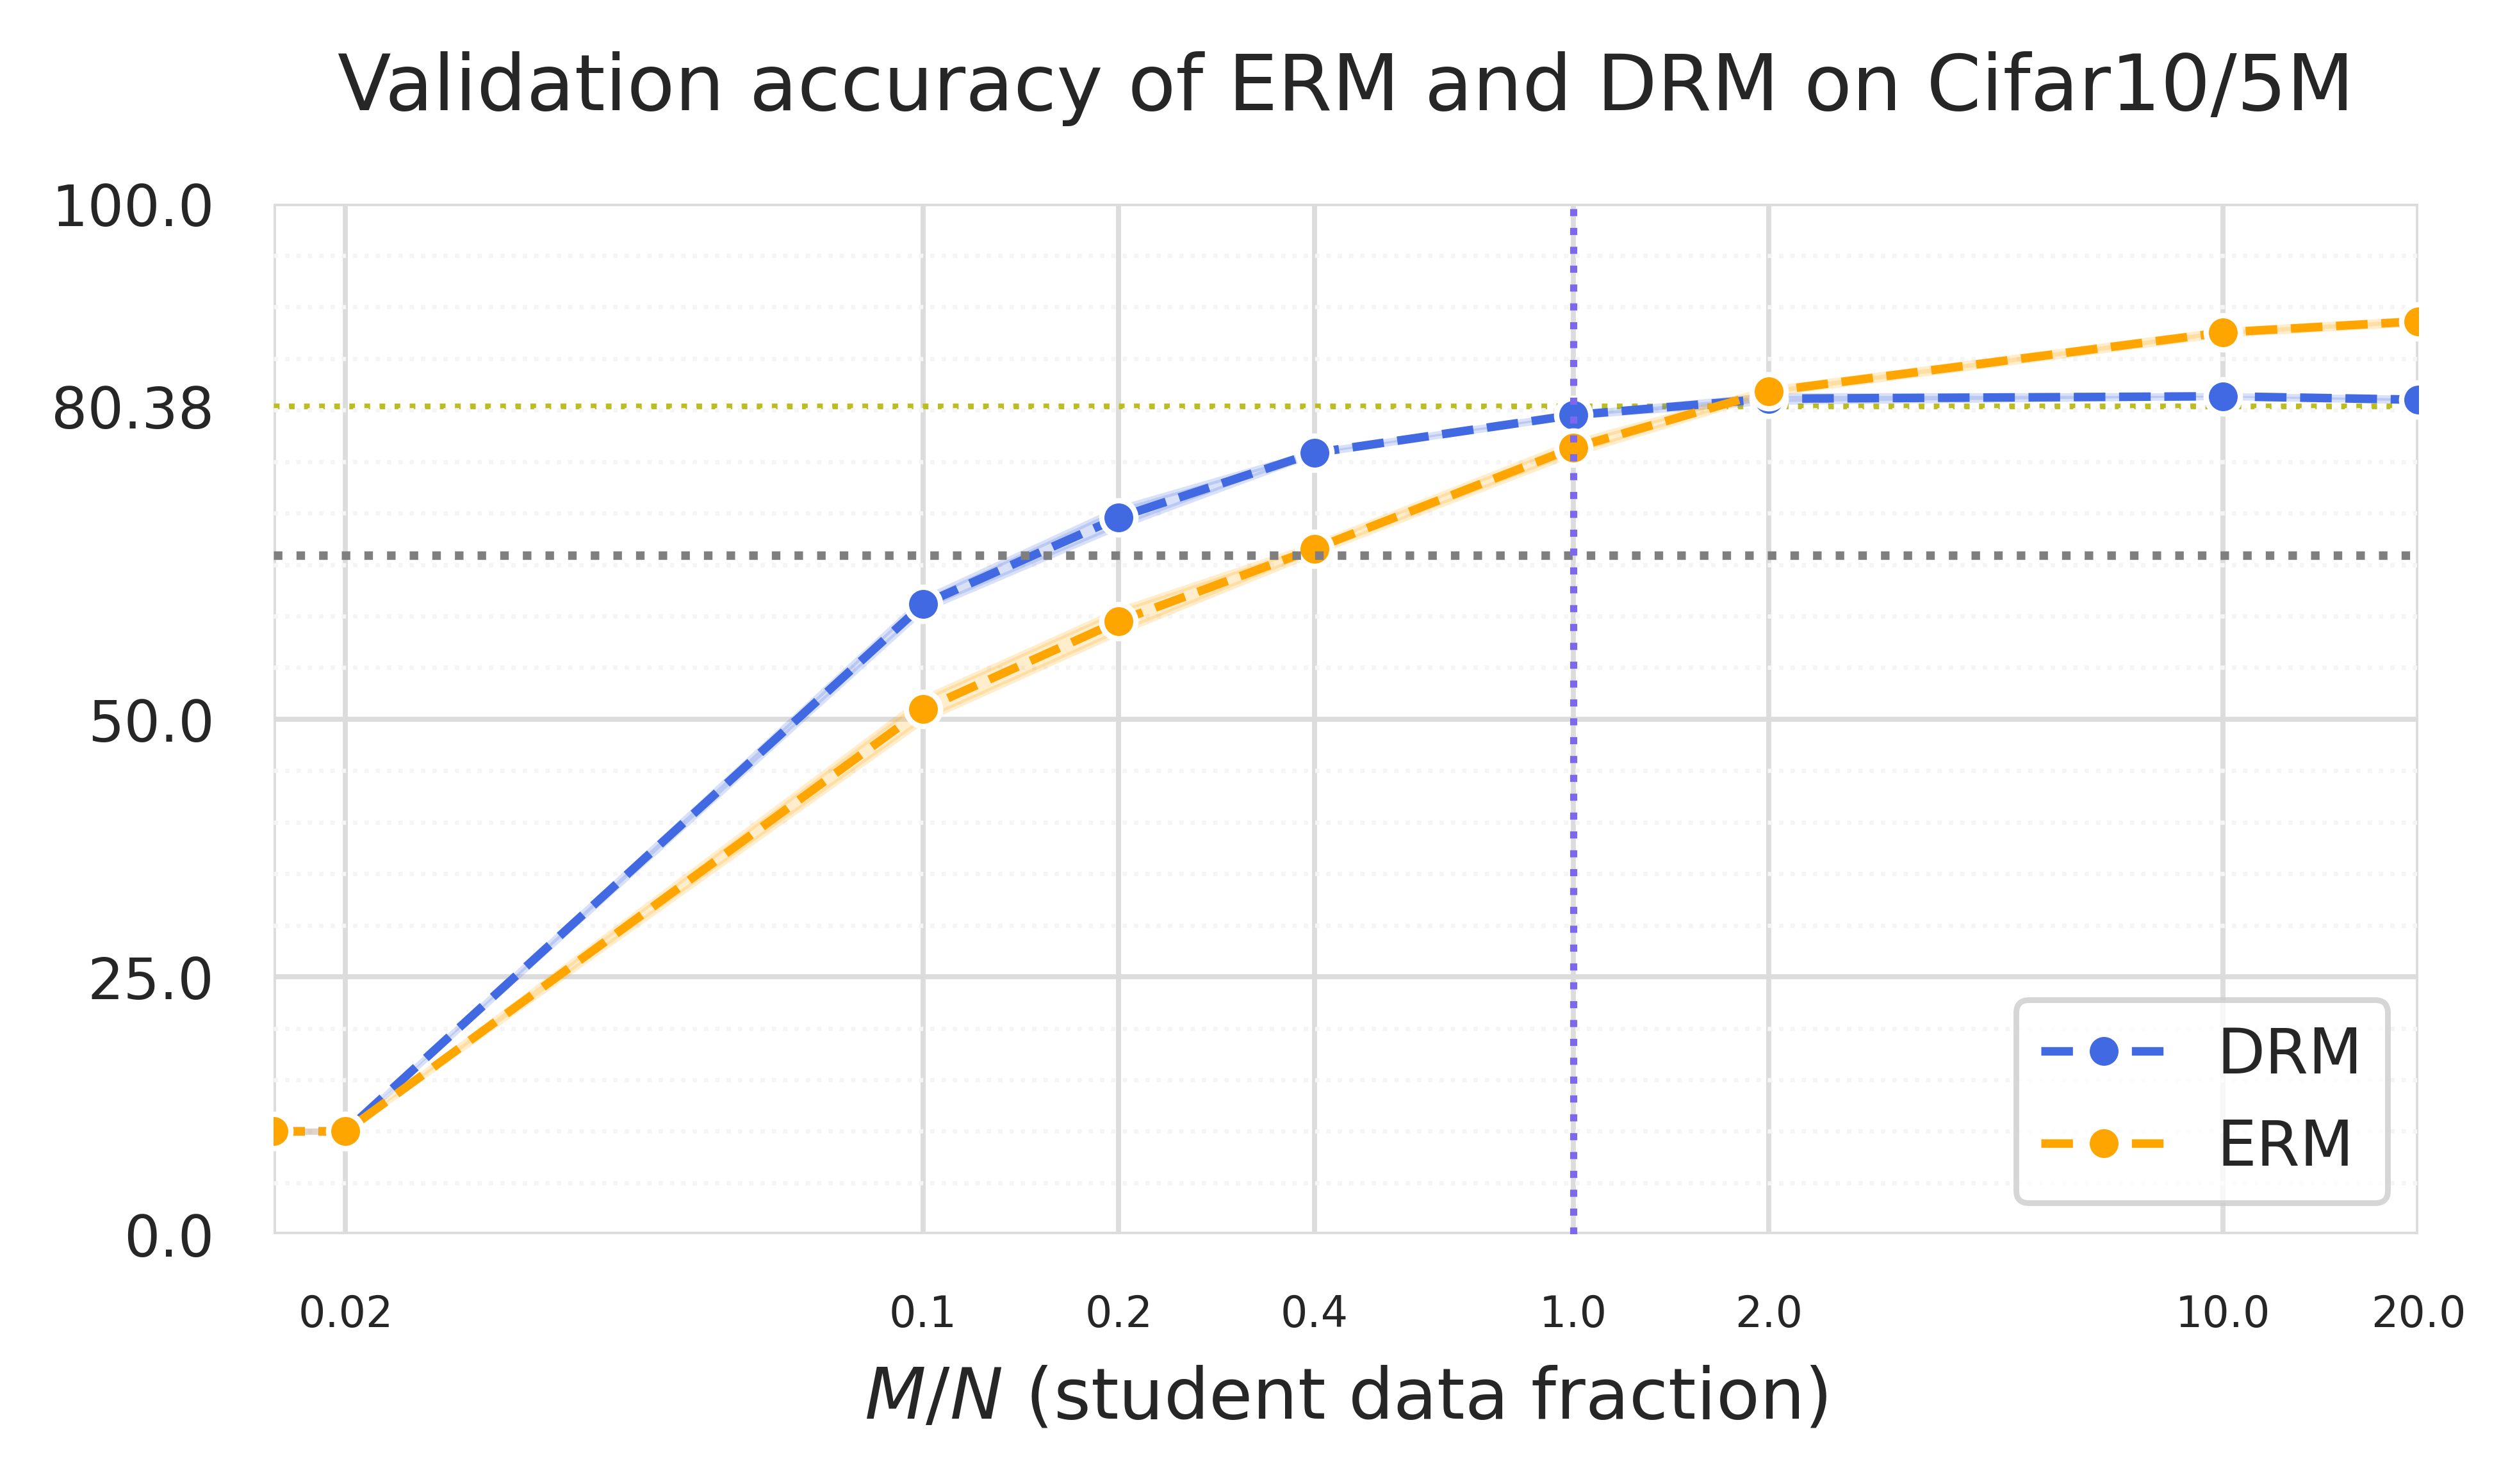

In [198]:
%matplotlib inline
sns.set_context("paper")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(5,3), sharey=True, dpi=800)
    colors = ['royalblue','orange','dimgray']


    _df = working_df.loc[working_df['alpha']==0.0]
    sns.lineplot(data=_df, x="buffer_size_p", y="final_val_acc_S", errorbar="sd",
                 markers=True, marker='o', color=colors[0], ls='--',ax=ax, label="distil.val")
    _df = working_df.loc[working_df['alpha']==1.0]
    sns.lineplot(data=_df, x="buffer_size_p", y="final_val_acc_S", errorbar="sd",
                markers=True, marker='o', color=colors[1], ls='--', ax=ax, label="labels.val")
    

    #ax.axvline(100.0, ls='--', color='tab:green')
    ax.axhline(teacher_val_accuracy_rec, ls=':', color="tab:gray")
    # ax.axhline(teacher_train_accuracy, ls='-', color=colors[2], label="b")
    # # props = dict(boxstyle='square', facecolor='white', alpha=0.5)
    # ax.text(0.01, 0.9, 'teacher.val', transform=ax.transAxes, 
    #            fontsize=10, verticalalignment='top', bbox=props)
    #ax.set_xscale('log')
    ax.set_xscale('symlog',linthresh=10e-2)
    ax.set_xlim([0.1,20.])
    ax.set_ylim([0.0,100.0])

    ax.tick_params(axis='both',  labelsize=9)
    ax.set_xticks(buffer_sizes_p)
    ax.set_xticklabels(['']+[ f'{l}' for l in buffer_sizes_p[1:]], fontsize=6)
    ax.tick_params(axis='x',  rotation=0)

    yticks = [0.0, 25.0, 50.0, teacher_val_accuracy, 100.0]
    plt.yticks(yticks)
    ax.set_yticklabels([0.0, 25.0, 50.0, f'{teacher_val_accuracy}', 100.0], fontsize=8)

    ax.axvline(x=1.0, color='mediumslateblue', linewidth=1.0, linestyle=':')

    # #ax.text(10.0,0, "Local", color="white", bbox={'facecolor': 'tab:green', 'alpha': 0.5, 'pad': 10})
    # ax.set_ylim(-1,10000.0)


    ax.set_title(f"Validation accuracy of ERM and DRM on Cifar10/5M", fontsize=11, y=1.05)
    ax.set_ylabel(r'', fontsize=11, x=-0.2)
    ax.set_xlabel(r'$M/N$ (student data fraction)', fontsize=10, y=+1)


    #ax[t].legend(title="Eigen-index", loc="upper left")
    # Shrink current axis's height by 10% on the bottom
    
    h, _ = ax.get_legend_handles_labels()
    ax.legend(h, ['DRM',
                  'ERM',
                  'teacher'], 
                title="", ncol=1, loc="lower right")


    # AESTHETICS control 
    ax.set_facecolor('white')
    [ax.spines[side].set_visible(False) for side in ax.spines]
    # major and minor grids
    ax.grid(which='major', color='gainsboro', linewidth=0.7)
    ax.grid(which='minor', color='whitesmoke', linestyle=':', linewidth=0.6)
    # Make the minor ticks and gridlines show.
    ax.minorticks_on()
    #ax.tick_params(which='minor', bottom=False, left=False)
    #fig.supxlabel(r' % of dataset used', fontsize=12, y=-0.1)

    a = ax.get_ygridlines()
    b = a[3]
    b.set_color('tab:olive')
    b.set_linewidth(0.8)
    b.set_linestyle(':')
    #sns.despine()
    plt.tight_layout()


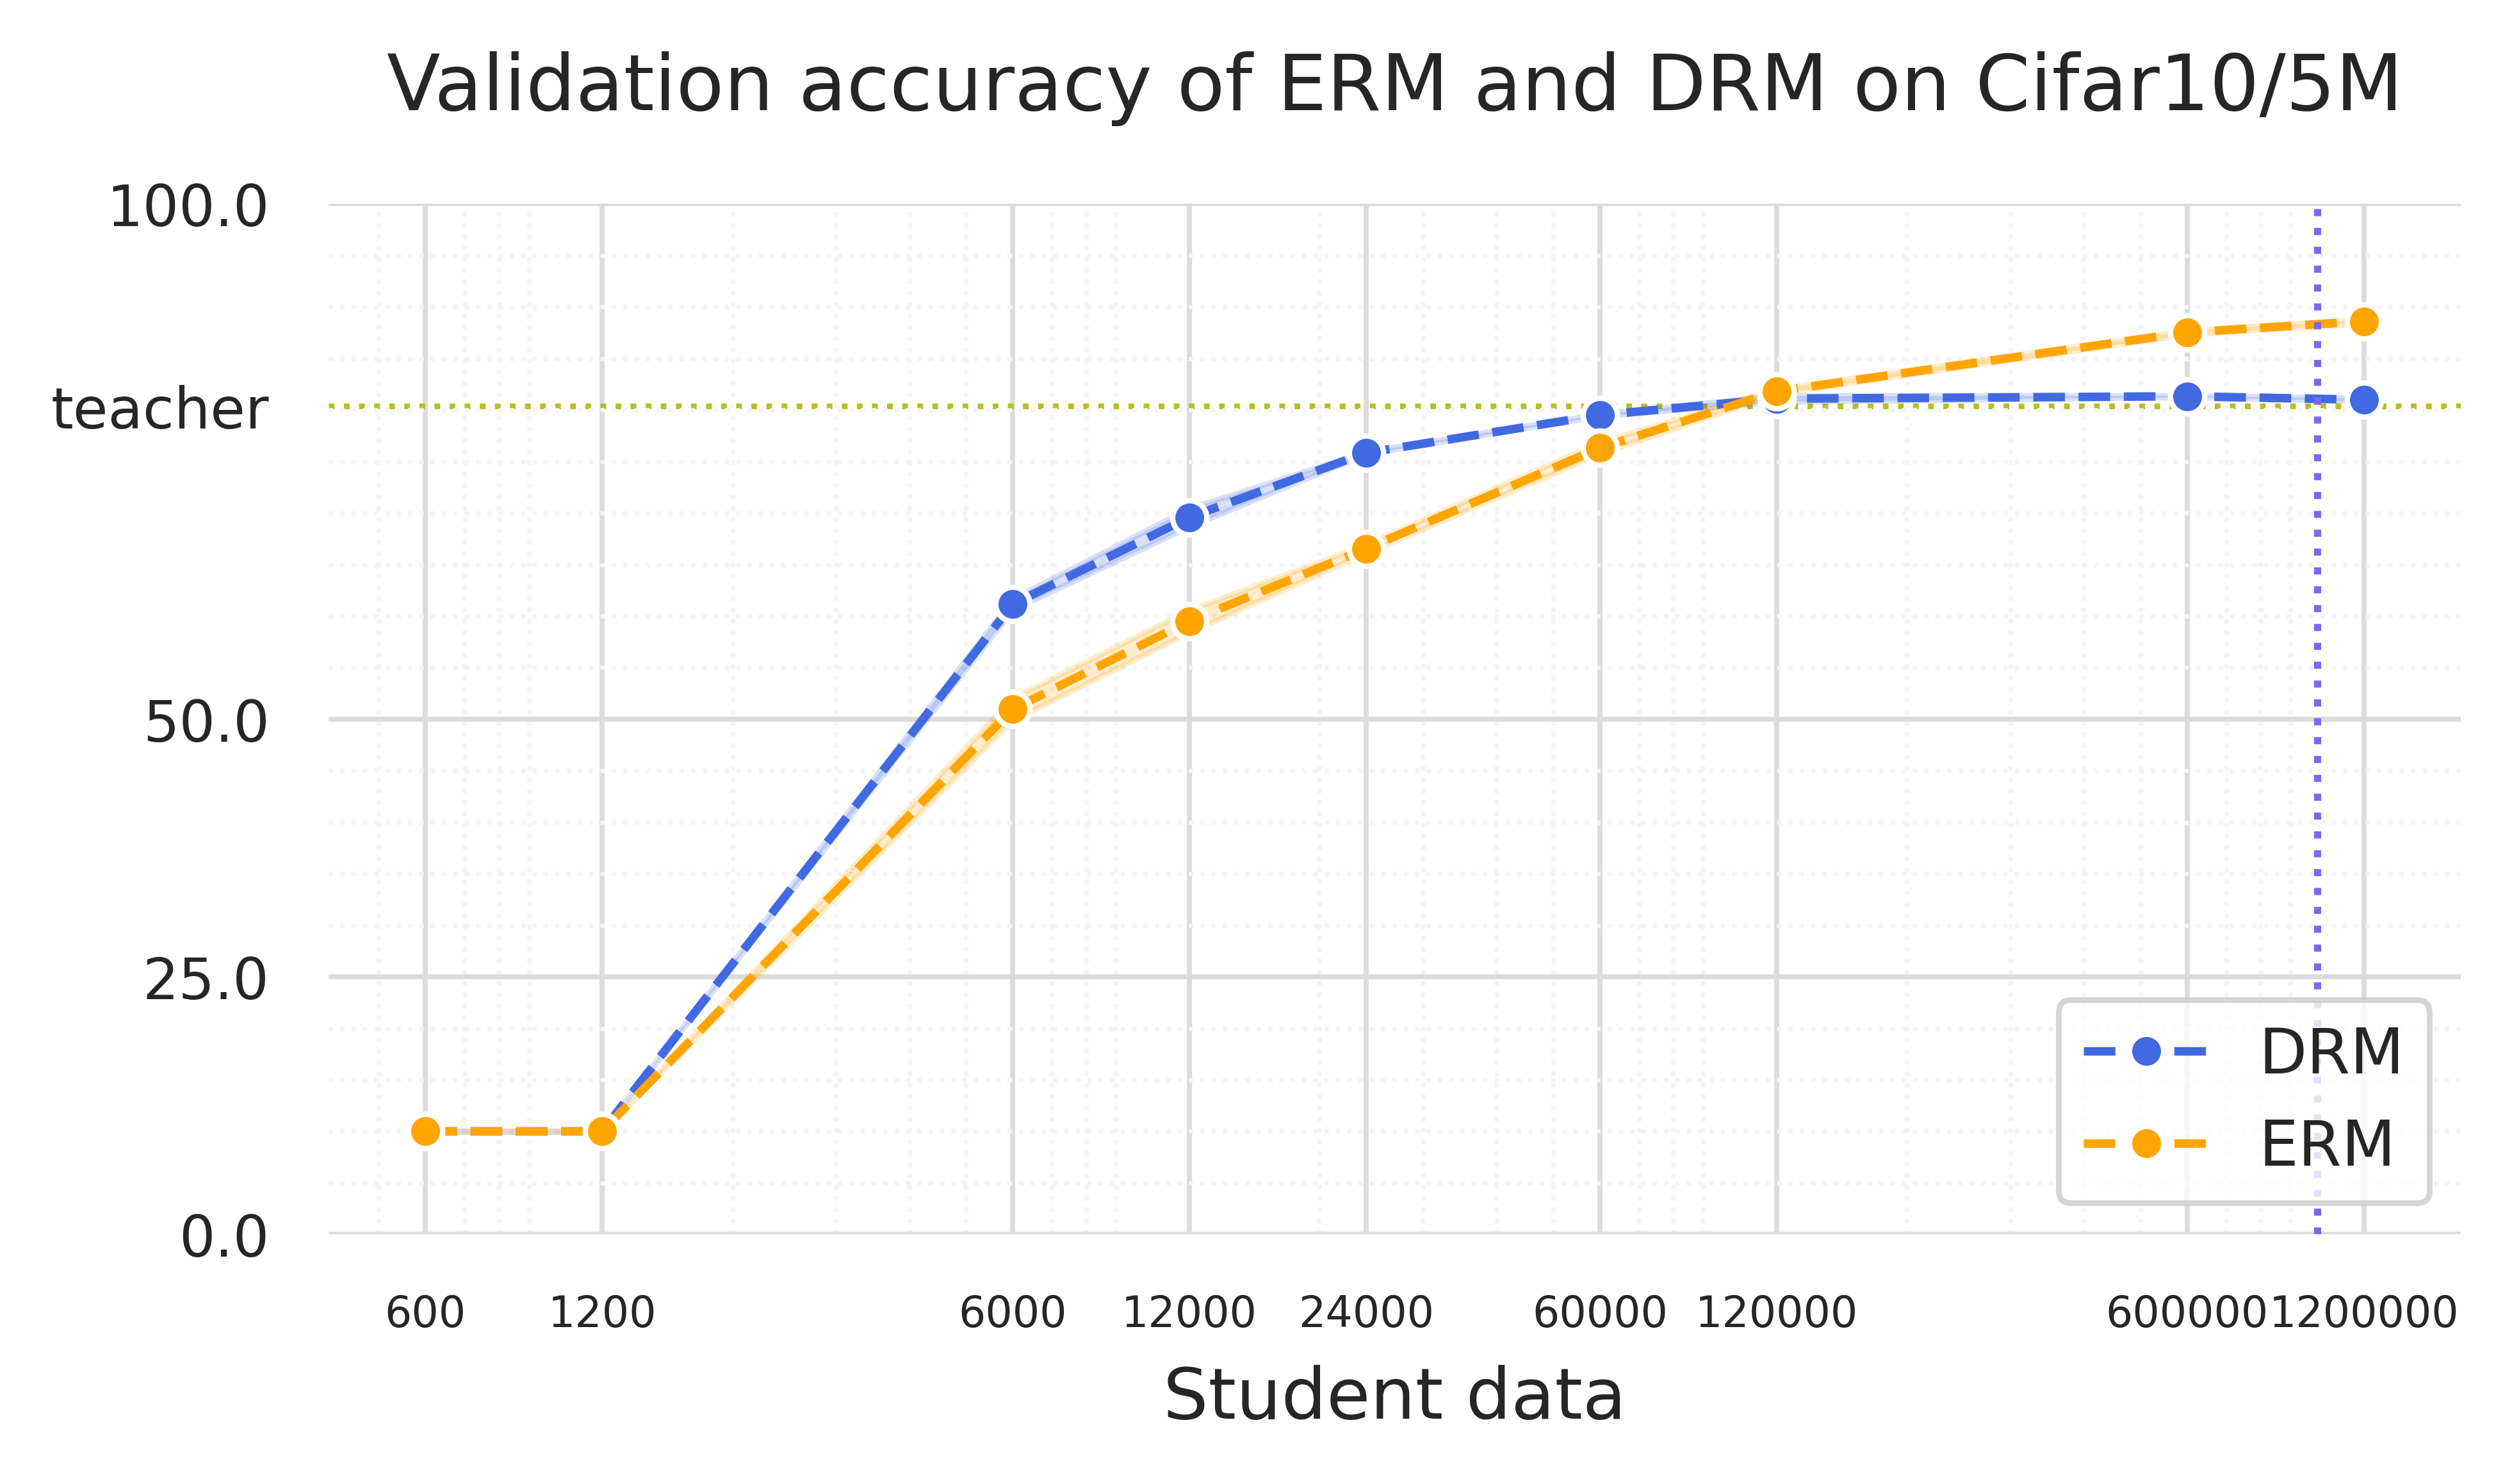

In [178]:
%matplotlib inline
sns.set_context("paper")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(5,3), sharey=True, dpi=800)
    colors = ['royalblue','orange','dimgray']


    _df = working_df.loc[working_df['alpha']==0.0]
    sns.lineplot(data=_df, x="buffer_size", y="final_val_acc_S", errorbar="sd",
                 markers=True, marker='o', color=colors[0], ls='--',ax=ax, label="distil.val")
    _df = working_df.loc[working_df['alpha']==1.0]
    sns.lineplot(data=_df, x="buffer_size", y="final_val_acc_S", errorbar="sd",
                markers=True, marker='o', color=colors[1], ls='--', ax=ax, label="labels.val")
    

    #ax.axvline(100.0, ls='--', color='tab:green')
    # ax.axhline(76.034, ls='--', color=colors[2], label="a")
    # ax.axhline(teacher_train_accuracy, ls='-', color=colors[2], label="b")
    # # props = dict(boxstyle='square', facecolor='white', alpha=0.5)
    # ax.text(0.01, 0.9, 'teacher.val', transform=ax.transAxes, 
    #            fontsize=10, verticalalignment='top', bbox=props)
    ax.set_xscale('log')
    #ax.set_xscale('symlog',linthresh=10e-2)
    #ax.set_xlim([0.1,0.4])
    ax.set_ylim([0.0,100.0])

    ax.tick_params(axis='both',  labelsize=9)
    ax.set_xticks(buffer_sizes)
    ax.set_xticklabels(buffer_sizes, fontsize=6)
    ax.tick_params(axis='x',  rotation=0)

    yticks = [0.0, 25.0, 50.0, teacher_val_accuracy, 100.0]
    plt.yticks(yticks)
    ax.set_yticklabels([0.0, 25.0, 50.0, 'teacher', 100.0], fontsize=8)

    ax.axvline(x=1000000, color='mediumslateblue', linewidth=1.0, linestyle=':')

    # #ax.text(10.0,0, "Local", color="white", bbox={'facecolor': 'tab:green', 'alpha': 0.5, 'pad': 10})
    # ax.set_ylim(-1,10000.0)


    ax.set_title(f"Validation accuracy of ERM and DRM on Cifar10/5M", fontsize=11, y=1.05)
    ax.set_ylabel(r'', fontsize=11, x=-0.2)
    ax.set_xlabel(r'Student data', fontsize=10, y=+1)


    #ax[t].legend(title="Eigen-index", loc="upper left")
    # Shrink current axis's height by 10% on the bottom
    
    h, _ = ax.get_legend_handles_labels()
    ax.legend(h, ['DRM',
                  'ERM',
                  'teacher'], 
                title="", ncol=1, loc="lower right")


    # AESTHETICS control 
    ax.set_facecolor('white')
    [ax.spines[side].set_visible(False) for side in ax.spines]
    # major and minor grids
    ax.grid(which='major', color='gainsboro', linewidth=0.7)
    ax.grid(which='minor', color='whitesmoke', linestyle=':', linewidth=0.6)
    # Make the minor ticks and gridlines show.
    ax.minorticks_on()
    #ax.tick_params(which='minor', bottom=False, left=False)
    #fig.supxlabel(r' % of dataset used', fontsize=12, y=-0.1)

    a = ax.get_ygridlines()
    b = a[3]
    b.set_color('tab:olive')
    b.set_linewidth(0.8)
    b.set_linestyle(':')
    #sns.despine()
    plt.tight_layout()


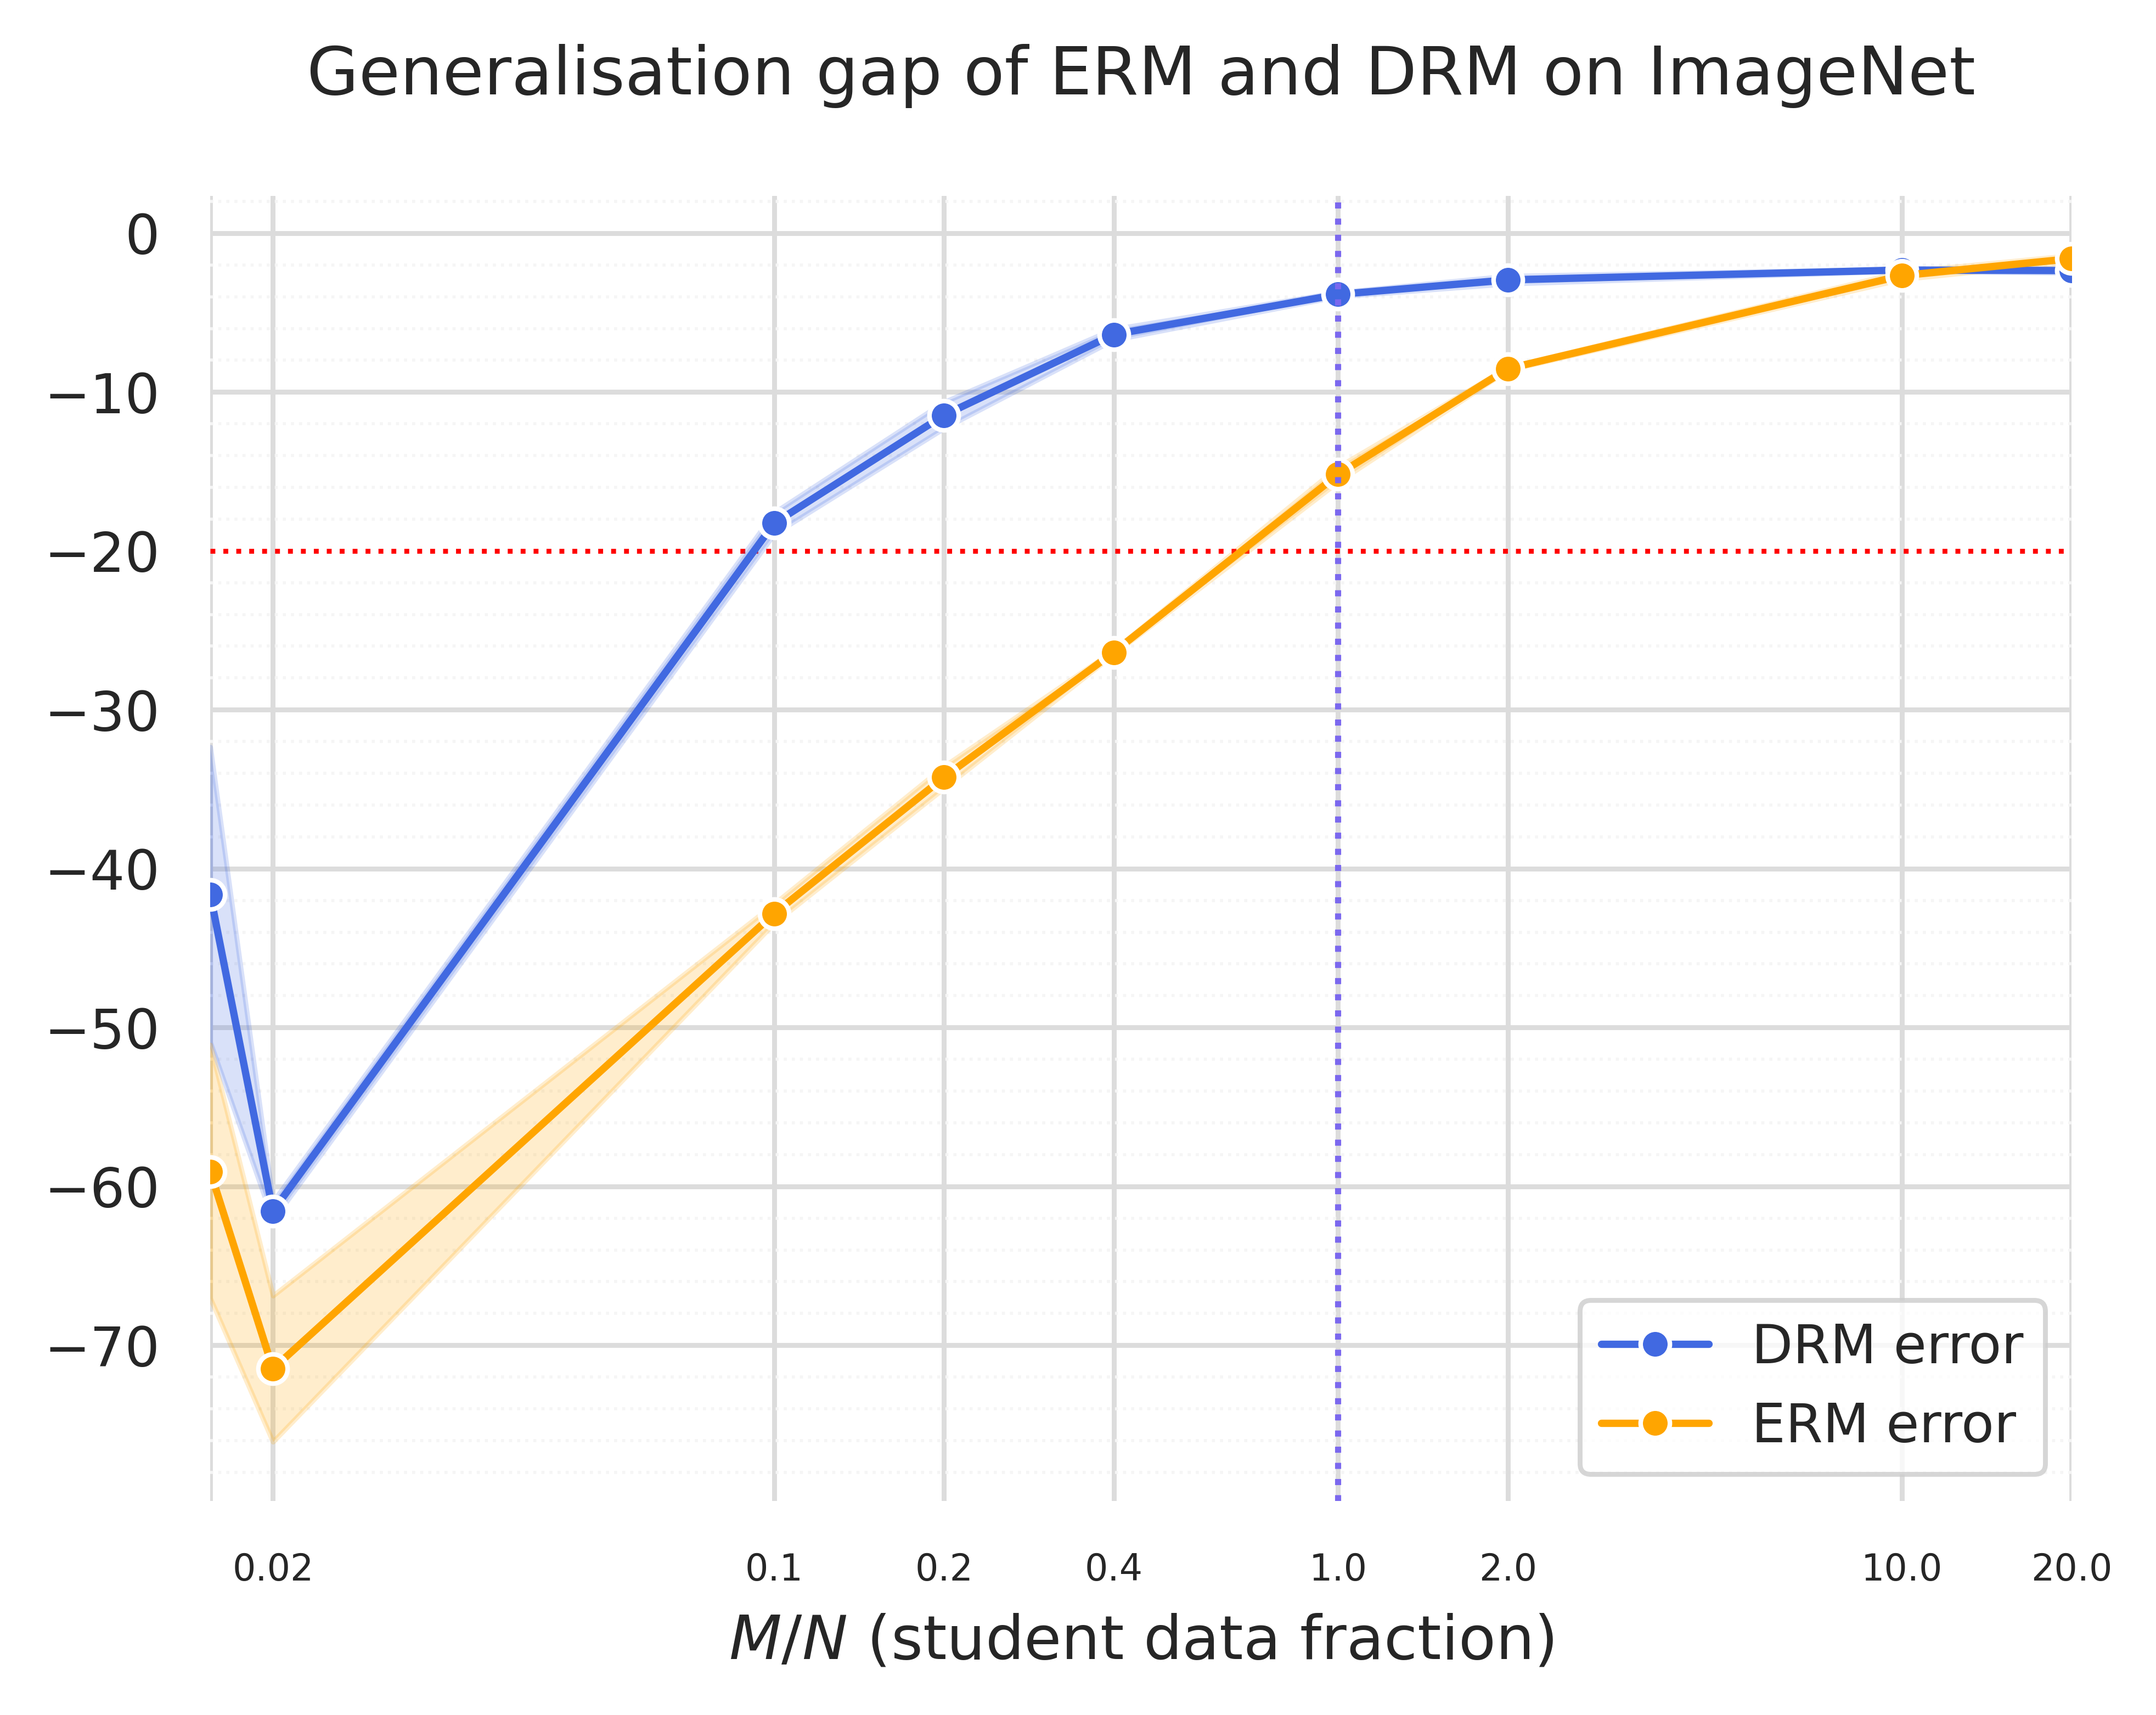

In [54]:
%matplotlib inline
sns.set_context("paper")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(5,4), sharey=True, dpi=800)
    colors = ['royalblue','orange','dimgray']



    _df = working_df.loc[working_df['alpha']==0.0]
    sns.lineplot(data=_df, x="buffer_size_p", y="generalization_gap", errorbar="sd",
                 markers=True, marker='o', color=colors[0], ls='-', ax=ax, label="DRM error")
    _df = working_df.loc[working_df['alpha']==1.0]
    sns.lineplot(data=_df, x="buffer_size_p", y="generalization_gap", errorbar="sd",
                markers=True, marker='o', color=colors[1], ls='-', ax=ax, label="ERM error")
    

    #ax.axvline(100.0, ls='--', color='tab:green')
    # ax.axhline(76.034, ls='--', color=colors[2], label="a")
    # ax.axhline(teacher_train_accuracy, ls='-', color=colors[2], label="b")
    # # props = dict(boxstyle='square', facecolor='white', alpha=0.5)
    # ax.text(0.01, 0.9, 'teacher.val', transform=ax.transAxes, 
    #            fontsize=10, verticalalignment='top', bbox=props)
    #ax.set_xscale('log')
    ax.set_xscale('symlog',linthresh=10e-2)
    ax.set_xlim([0.1,0.4])
    #ax.set_ylim([0.0,100.0])

    ax.tick_params(axis='both',  labelsize=9)
    ax.set_xticks(buffer_sizes_p)
    ax.set_xticklabels(['']+[ f'{l}' for l in buffer_sizes_p[1:]], fontsize=6)
    ax.tick_params(axis='x',  rotation=0)

    ax.axvline(x=1.0, color='mediumslateblue', linewidth=1.0, linestyle=':')

    #yticks = [0.0, 25.0, 50.0, teacher_val_accuracy, 100.0]
    #plt.yticks(yticks)
    #ax.set_yticklabels([0.0, 25.0, 50.0, 'teacher.val', 100.0], fontsize=8)



    # #ax.text(10.0,0, "Local", color="white", bbox={'facecolor': 'tab:green', 'alpha': 0.5, 'pad': 10})
    # ax.set_ylim(-1,10000.0)


    ax.set_title(f"Generalisation gap of ERM and DRM on ImageNet", fontsize=11, y=1.05)
    ax.set_ylabel(r'', fontsize=11, x=-0.2)
    ax.set_xlabel(r'$M/N$ (student data fraction)', fontsize=10, y=+1)


    #ax[t].legend(title="Eigen-index", loc="upper left")
    # Shrink current axis's height by 10% on the bottom
    
    h, _ = ax.get_legend_handles_labels()
    ax.legend(h, ['DRM error',
                  'ERM error'], 
                title="", ncol=1, loc="lower right")


    # AESTHETICS control 
    ax.set_facecolor('white')
    [ax.spines[side].set_visible(False) for side in ax.spines]
    # major and minor grids
    ax.grid(which='major', color='gainsboro', linewidth=0.8)
    ax.grid(which='minor', color='whitesmoke', linestyle=':', linewidth=0.5)
    # Make the minor ticks and gridlines show.
    ax.minorticks_on()
    #ax.tick_params(which='minor', bottom=False, left=False)
    #fig.supxlabel(r' % of dataset used', fontsize=12, y=-0.1)

    a = ax.get_ygridlines()
    b = a[6]
    b.set_color('red')
    b.set_linewidth(0.8)
    b.set_linestyle(':')
    #sns.despine()
    plt.tight_layout()


# Cifar 5M big teacher -> small student

In [71]:
logs_path = './logs/results/cifar5m/small/logs.txt'
results = []
with open(logs_path) as f:
    while line := f.readline():
        results.append(json.loads(line))

In [72]:
res_df_small = pd.DataFrame(results)
res_df_small

distributed   lr  checkpoints  pretrained  optim_wd  optim_adam   
0            no  0.1         True       False     0.001       False  \
1            no  0.1         True       False     0.001       False   
2            no  0.1         True       False     0.001       False   
3            no  0.1         True       False     0.001       False   
4            no  0.1         True       False     0.001       False   
..          ...  ...          ...         ...       ...         ...   
107          no  0.1         True       False     0.001       False   
108          no  0.1         True       False     0.001       False   
109          no  0.1         True       False     0.001       False   
110          no  0.1         True       False     0.001       False   
111          no  0.1         True       False     0.001       False   

     optim_mom  optim_warmup  optim_nesterov  optim_cosineanneal  ...    K   
0            0             5           False                True  ...  100  \
1            0             5           False                True  ...  100   
2            0             5           False                True  ...  100   
3            0             5           False                True  ...  100   
4            0             5           False                True  ...  100   
..         ...           ...             ...                 ...  ...  ...   
107          0             5           False                True  ...  100   
108          0             5           False                True  ...  100   
109          0             5           False                True  ...  100   
110          0             5           False                True  ...  100   
111          0             5           False                True  ...  100   

     N_BLOCKS  gamma  final_val_acc_D buffer_train_time  final_train_acc_S   
0           1    1.0            85.95        771.529704          91.430000  \
1           1    1.0            85.95        779.120204          81.365000   
2           1    1.0            85.95        257.423453          65.600000   
3           1    1.0            85.95        267.612314          79.500000   
4           1    1.0            85.95        268.595036          62.300000   
..        ...    ...              ...               ...                ...   
107         1    1.0            85.95        337.364179          79.475000   
108         1    1.0            85.95        336.627103          79.991667   
109         1    1.0            85.95        468.283016          92.033333   
110         1    1.0            85.95        469.586303          92.550000   
111         1    1.0            85.95        478.294963          93.241667   

    final_val_acc_S  final_train_agreement  final_val_agreement   
0             69.71              83.405000                71.64  \
1             79.36              86.815000                83.88   
2              9.47              68.500000                 8.71   
3             10.67              71.900000                11.32   
4              9.60              64.500000                10.41   
..              ...                    ...                  ...   
107           76.09              84.741667                79.57   
108           76.03              84.841667                79.18   
109           65.32              83.283333                66.81   
110           65.27              83.133333                67.00   
111           66.83              83.450000                68.59   

     final_val_function_distance  
0                       0.285505  
1                       0.159231  
2                       0.728220  
3                       0.730435  
4                       0.728139  
..                           ...  
107                     0.198113  
108                     0.197499  
109                     0.330255  
110                     0.325535  
111                     0.314438  

[112 rows x 41 columns]

In [73]:
res_df_small.columns

Index(['distributed', 'lr', 'checkpoints', 'pretrained', 'optim_wd',
       'optim_adam', 'optim_mom', 'optim_warmup', 'optim_nesterov',
       'optim_cosineanneal', 'n_epochs', 'n_epochs_stud', 'batch_size',
       'validate_subset', 'gpus_id', 'seed', 'notes', 'non_verbose',
       'disable_log', 'validation', 'ignore_other_metrics', 'debug_mode',
       'nowand', 'wandb_entity', 'wandb_project', 'wandb_name', 'buffer_size',
       'minibatch_size', 'alpha', 'MSE', 'distillation_type', 'K', 'N_BLOCKS',
       'gamma', 'final_val_acc_D', 'buffer_train_time', 'final_train_acc_S',
       'final_val_acc_S', 'final_train_agreement', 'final_val_agreement',
       'final_val_function_distance'],
      dtype='object')

In [93]:
buffer_sizes_sm = sorted(list(res_df_small['buffer_size'].unique()))
buffer_sizes_sm

[600, 1000, 1200, 6000, 10000, 12000, 20000, 100000, 200000, 400000, 1000000]

In [94]:
teacher_val_accuracy_sm = res_df_small['final_val_acc_D'][0]
teacher_val_accuracy_sm # the teacher was trained on 1MLN samples from CIFAR 5M

85.95

In [78]:
res_df_small['buffer_size_p'] = res_df_small['buffer_size']/1000000
res_df_small['generalization_gap'] = res_df_small['final_val_acc_S']-res_df_small['final_train_acc_S']
working_df_sm = res_df_small
working_df_sm

distributed   lr  checkpoints  pretrained  optim_wd  optim_adam   
0            no  0.1         True       False     0.001       False  \
1            no  0.1         True       False     0.001       False   
2            no  0.1         True       False     0.001       False   
3            no  0.1         True       False     0.001       False   
4            no  0.1         True       False     0.001       False   
..          ...  ...          ...         ...       ...         ...   
107          no  0.1         True       False     0.001       False   
108          no  0.1         True       False     0.001       False   
109          no  0.1         True       False     0.001       False   
110          no  0.1         True       False     0.001       False   
111          no  0.1         True       False     0.001       False   

     optim_mom  optim_warmup  optim_nesterov  optim_cosineanneal  ...  gamma   
0            0             5           False                True  ...    1.0  \
1            0             5           False                True  ...    1.0   
2            0             5           False                True  ...    1.0   
3            0             5           False                True  ...    1.0   
4            0             5           False                True  ...    1.0   
..         ...           ...             ...                 ...  ...    ...   
107          0             5           False                True  ...    1.0   
108          0             5           False                True  ...    1.0   
109          0             5           False                True  ...    1.0   
110          0             5           False                True  ...    1.0   
111          0             5           False                True  ...    1.0   

     final_val_acc_D  buffer_train_time  final_train_acc_S final_val_acc_S   
0              85.95         771.529704          91.430000           69.71  \
1              85.95         779.120204          81.365000           79.36   
2              85.95         257.423453          65.600000            9.47   
3              85.95         267.612314          79.500000           10.67   
4              85.95         268.595036          62.300000            9.60   
..               ...                ...                ...             ...   
107            85.95         337.364179          79.475000           76.09   
108            85.95         336.627103          79.991667           76.03   
109            85.95         468.283016          92.033333           65.32   
110            85.95         469.586303          92.550000           65.27   
111            85.95         478.294963          93.241667           66.83   

     final_train_agreement final_val_agreement  final_val_function_distance   
0                83.405000               71.64                     0.285505  \
1                86.815000               83.88                     0.159231   
2                68.500000                8.71                     0.728220   
3                71.900000               11.32                     0.730435   
4                64.500000               10.41                     0.728139   
..                     ...                 ...                          ...   
107              84.741667               79.57                     0.198113   
108              84.841667               79.18                     0.197499   
109              83.283333               66.81                     0.330255   
110              83.133333               67.00                     0.325535   
111              83.450000               68.59                     0.314438   

     buffer_size_p  generalization_gap  
0            0.020          -21.720000  
1            0.020           -2.005000  
2            0.001          -56.130000  
3            0.001          -68.830000  
4            0.001          -52.700000  
..             ...                 ...  
107          0.01

In [79]:
buffer_sizes_p_sm = sorted(working_df['buffer_size_p'].unique())
buffer_sizes_p_sm

[0.01, 0.02, 0.1, 0.2, 0.4, 1.0, 2.0, 10.0, 20.0]

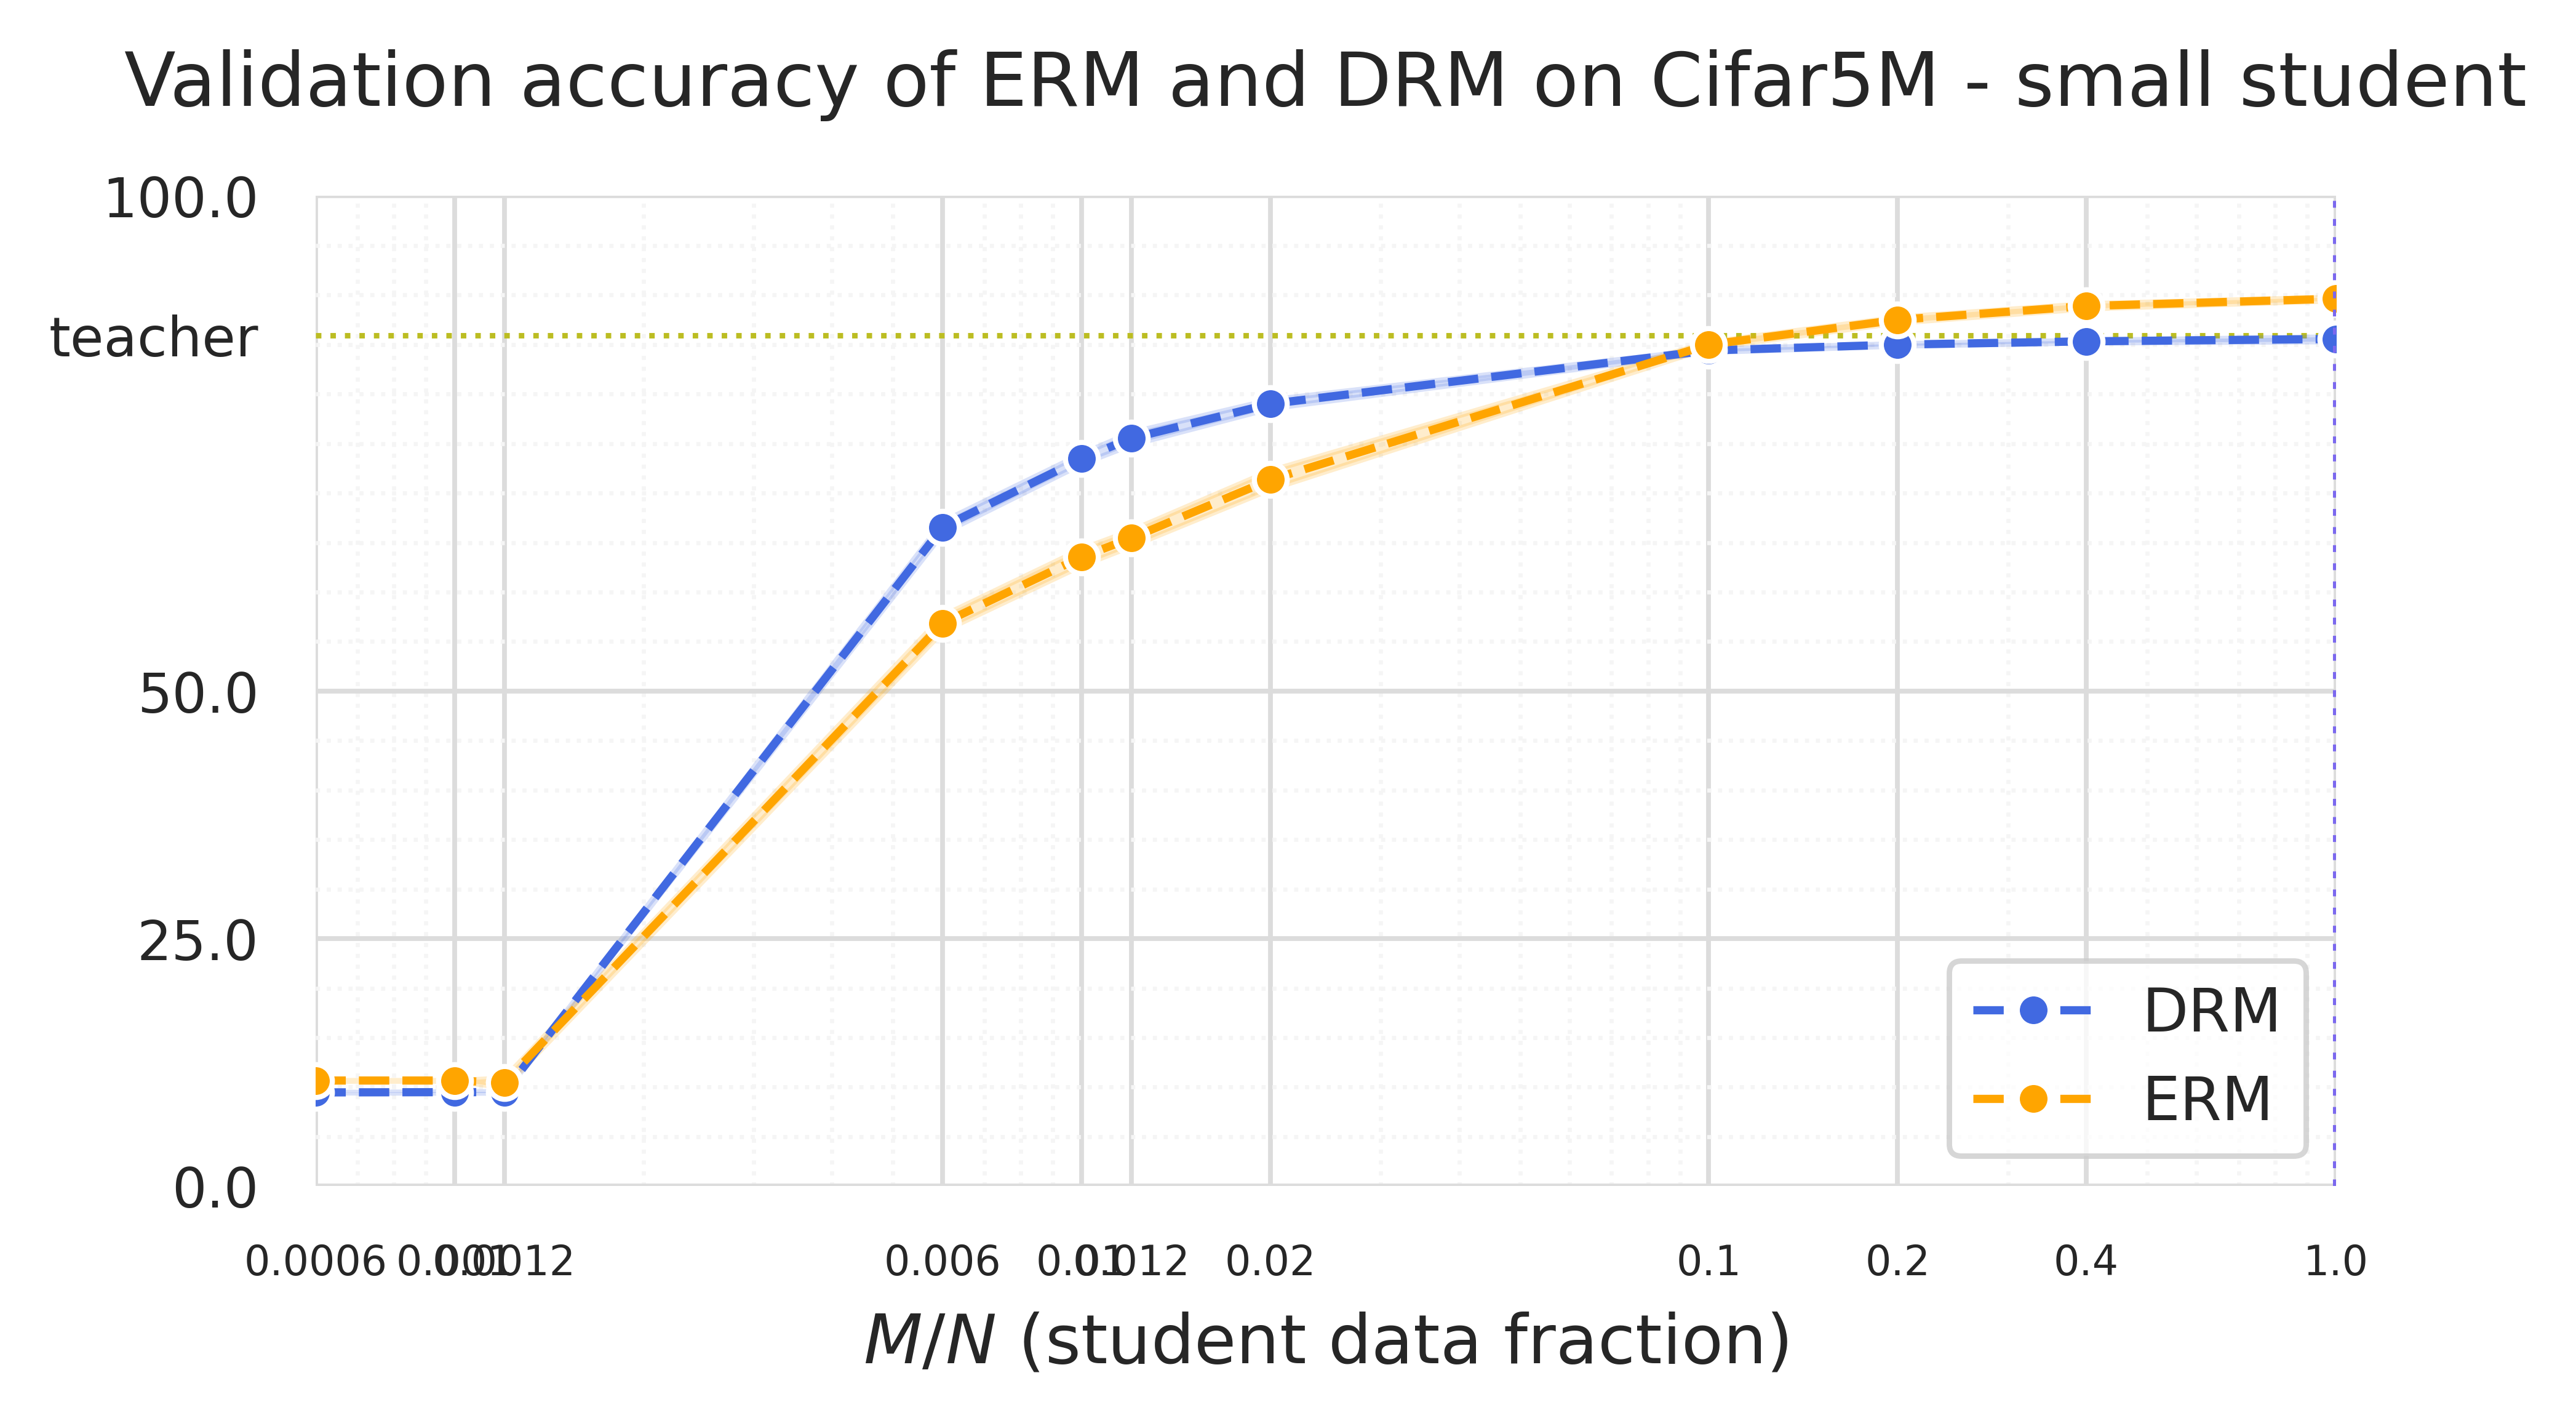

In [59]:
%matplotlib inline
sns.set_context("paper")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(5,3), sharey=True, dpi=800)
    colors = ['royalblue','orange','dimgray']


    _df = working_df.loc[working_df['alpha']==0.0]
    sns.lineplot(data=_df, x="buffer_size_p", y="final_val_acc_S", errorbar="sd",
                 markers=True, marker='o', color=colors[0], ls='--',ax=ax, label="distil.val")
    _df = working_df.loc[working_df['alpha']==1.0]
    sns.lineplot(data=_df, x="buffer_size_p", y="final_val_acc_S", errorbar="sd",
                markers=True, marker='o', color=colors[1], ls='--', ax=ax, label="labels.val")
    

    #ax.axvline(100.0, ls='--', color='tab:green')
    # ax.axhline(76.034, ls='--', color=colors[2], label="a")
    # ax.axhline(teacher_train_accuracy, ls='-', color=colors[2], label="b")
    # # props = dict(boxstyle='square', facecolor='white', alpha=0.5)
    # ax.text(0.01, 0.9, 'teacher.val', transform=ax.transAxes, 
    #            fontsize=10, verticalalignment='top', bbox=props)
    ax.set_xscale('log')
    #ax.set_xscale('symlog',linthresh=10e-2)
    ax.set_xlim([0.1,0.4])
    ax.set_ylim([0.0,100.0])

    ax.tick_params(axis='both',  labelsize=9)
    ax.set_xticks(buffer_sizes_p)
    ax.set_xticklabels([ f'{l}' for l in buffer_sizes_p[:]], fontsize=6)
    ax.tick_params(axis='x',  rotation=0)

    yticks = [0.0, 25.0, 50.0, teacher_val_accuracy, 100.0]
    plt.yticks(yticks)
    ax.set_yticklabels([0.0, 25.0, 50.0, 'teacher', 100.0], fontsize=8)

    ax.axvline(x=1.0, color='mediumslateblue', linewidth=1.0, linestyle=':')

    # #ax.text(10.0,0, "Local", color="white", bbox={'facecolor': 'tab:green', 'alpha': 0.5, 'pad': 10})
    # ax.set_ylim(-1,10000.0)


    ax.set_title(f"Validation accuracy of ERM and DRM on Cifar5M - small student", fontsize=11, y=1.05)
    ax.set_ylabel(r'', fontsize=11, x=-0.2)
    ax.set_xlabel(r'$M/N$ (student data fraction)', fontsize=10, y=+1)


    #ax[t].legend(title="Eigen-index", loc="upper left")
    # Shrink current axis's height by 10% on the bottom
    
    h, _ = ax.get_legend_handles_labels()
    ax.legend(h, ['DRM',
                  'ERM',
                  'teacher'], 
                title="", ncol=1, loc="lower right")


    # AESTHETICS control 
    ax.set_facecolor('white')
    [ax.spines[side].set_visible(False) for side in ax.spines]
    # major and minor grids
    ax.grid(which='major', color='gainsboro', linewidth=0.7)
    ax.grid(which='minor', color='whitesmoke', linestyle=':', linewidth=0.6)
    # Make the minor ticks and gridlines show.
    ax.minorticks_on()
    #ax.tick_params(which='minor', bottom=False, left=False)
    #fig.supxlabel(r' % of dataset used', fontsize=12, y=-0.1)

    a = ax.get_ygridlines()
    b = a[3]
    b.set_color('tab:olive')
    b.set_linewidth(0.8)
    b.set_linestyle(':')
    #sns.despine()
    plt.tight_layout()


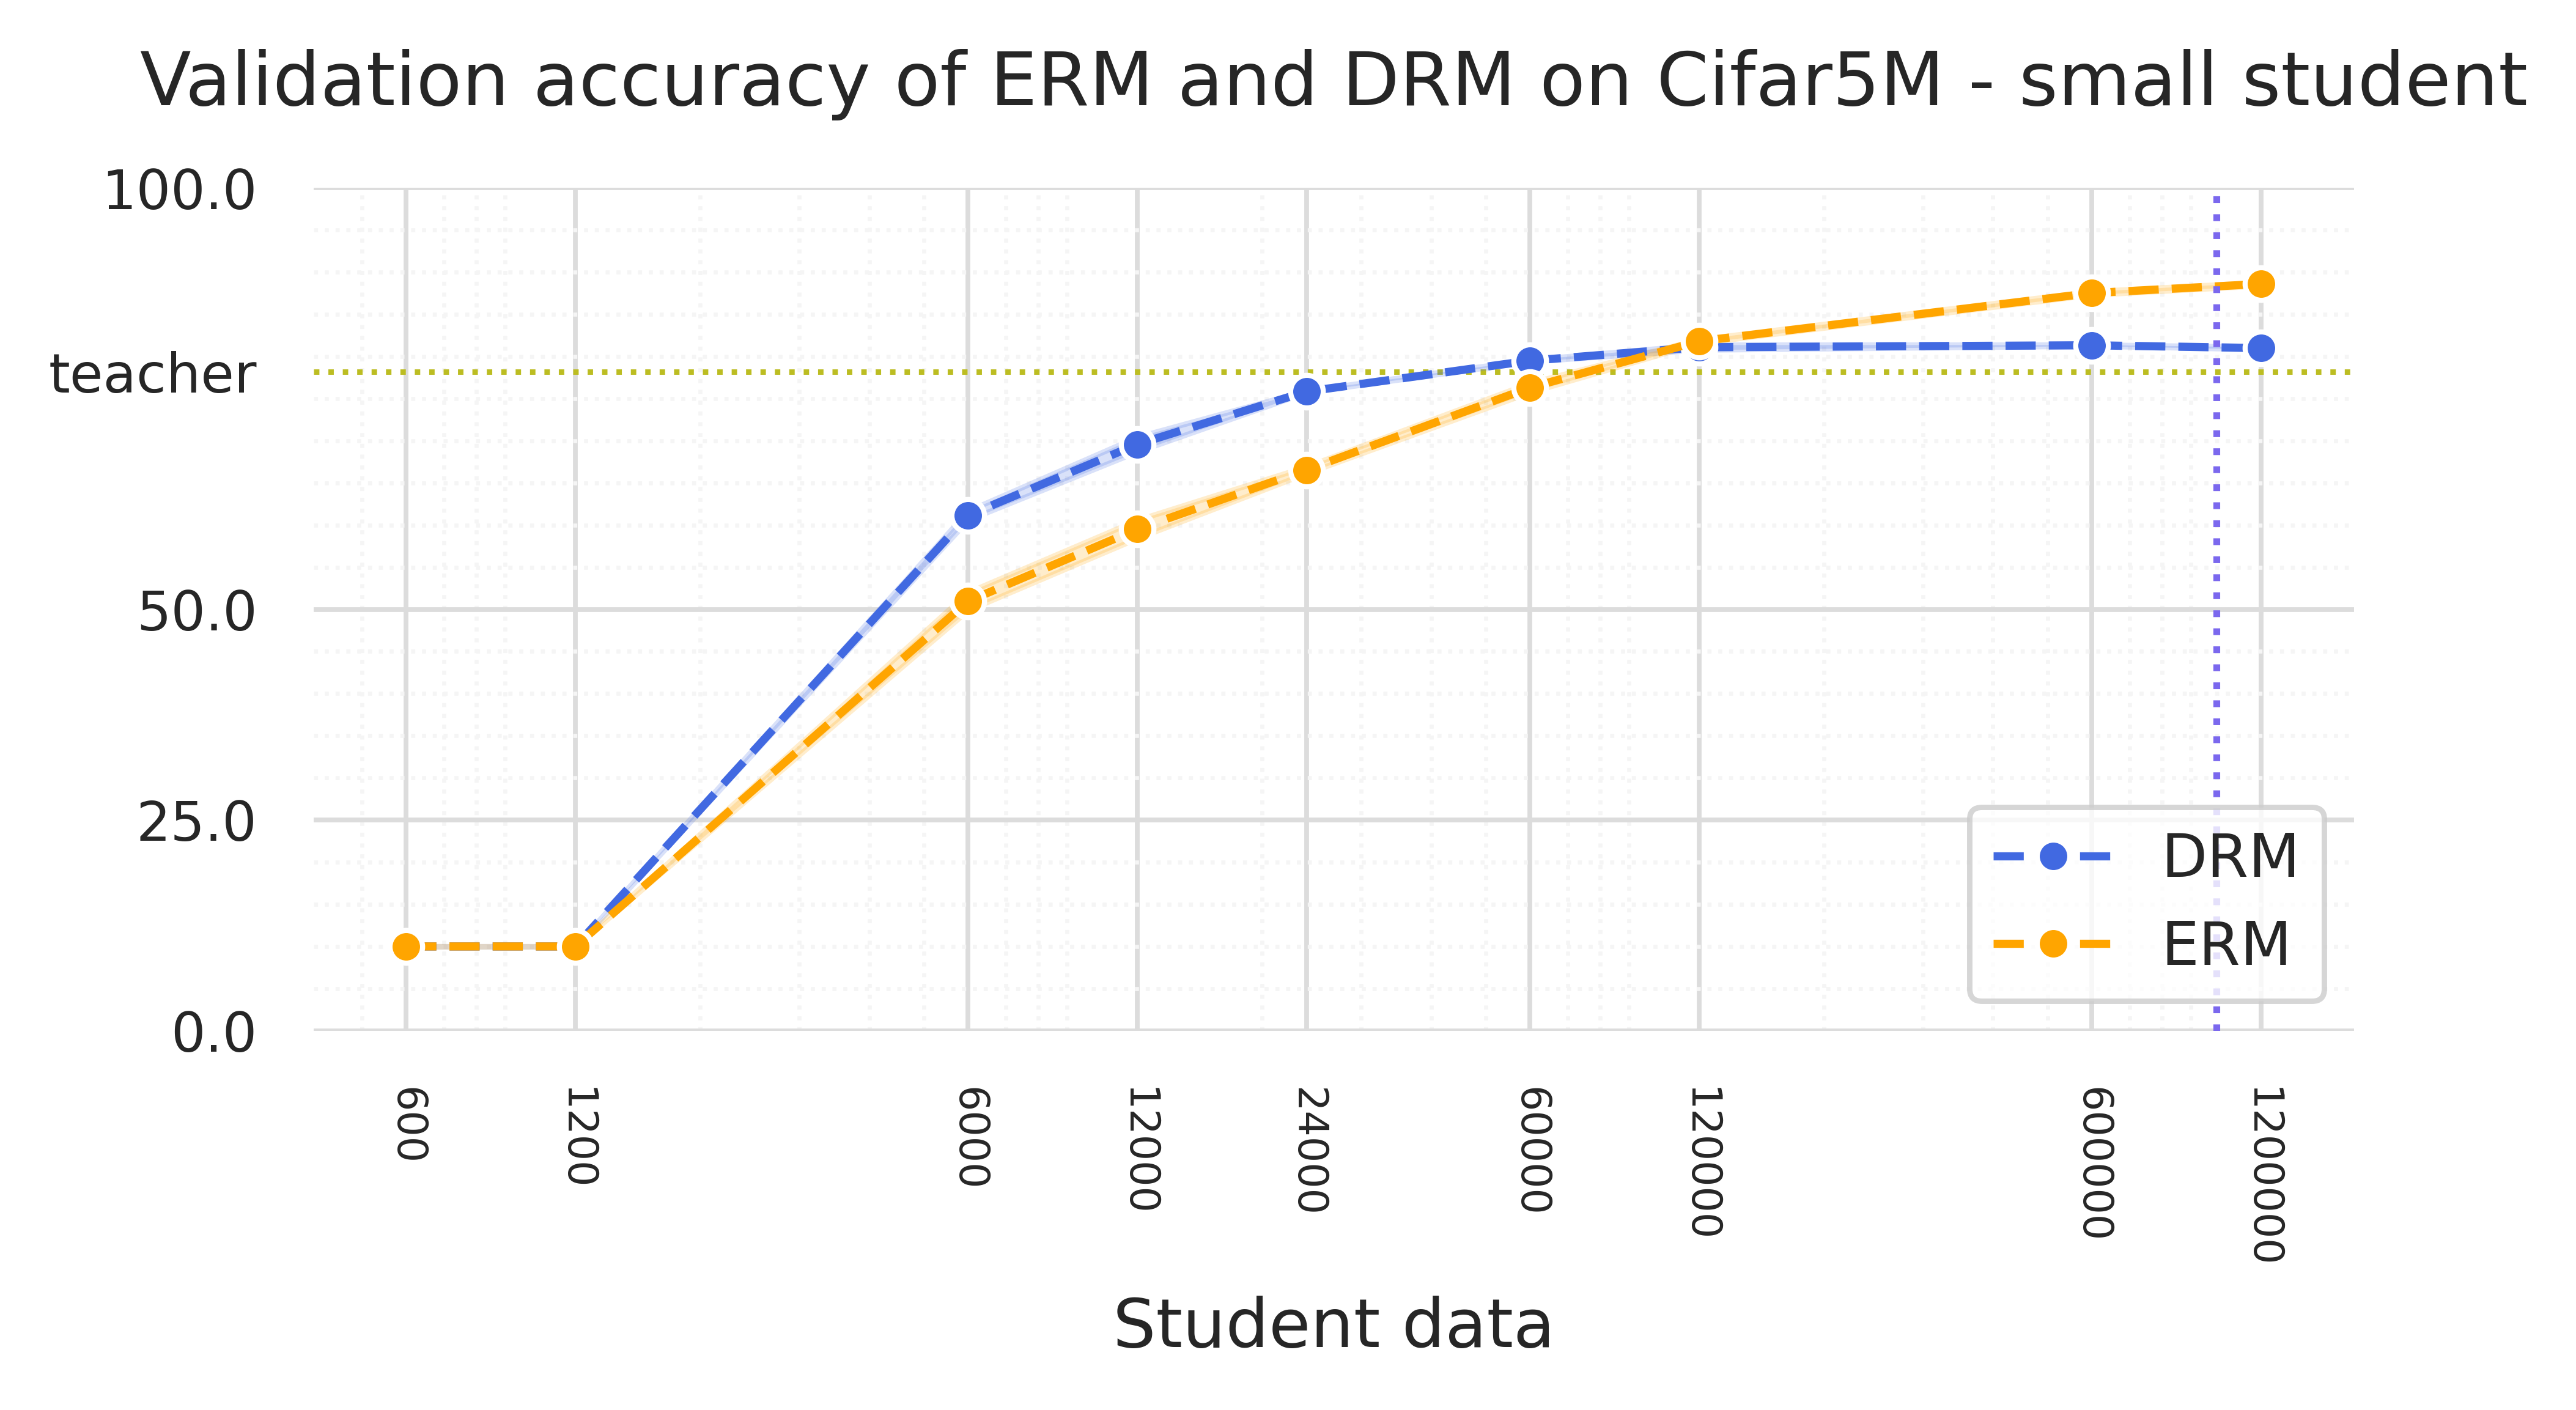

In [95]:
%matplotlib inline
sns.set_context("paper")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(5,3), sharey=True, dpi=800)
    colors = ['royalblue','orange','dimgray']


    _df = working_df.loc[working_df['alpha']==0.0]
    sns.lineplot(data=_df, x="buffer_size", y="final_val_acc_S", errorbar="sd",
                 markers=True, marker='o', color=colors[0], ls='--',ax=ax, label="distil.val")
    _df = working_df.loc[working_df['alpha']==1.0]
    sns.lineplot(data=_df, x="buffer_size", y="final_val_acc_S", errorbar="sd",
                markers=True, marker='o', color=colors[1], ls='--', ax=ax, label="labels.val")
    

    #ax.axvline(100.0, ls='--', color='tab:green')
    # ax.axhline(76.034, ls='--', color=colors[2], label="a")
    # ax.axhline(teacher_train_accuracy, ls='-', color=colors[2], label="b")
    # # props = dict(boxstyle='square', facecolor='white', alpha=0.5)
    # ax.text(0.01, 0.9, 'teacher.val', transform=ax.transAxes, 
    #            fontsize=10, verticalalignment='top', bbox=props)
    ax.set_xscale('log')
    #ax.set_xscale('symlog',linthresh=10e-2)
    #ax.set_xlim([0.1,0.4])
    ax.set_ylim([0.0,100.0])

    ax.tick_params(axis='both',  labelsize=9)
    ax.set_xticks(buffer_sizes)
    ax.set_xticklabels(buffer_sizes, fontsize=6)
    ax.tick_params(axis='x',  rotation=-90)

    yticks = [0.0, 25.0, 50.0, teacher_val_accuracy, 100.0]
    plt.yticks(yticks)
    ax.set_yticklabels([0.0, 25.0, 50.0, 'teacher', 100.0], fontsize=8)

    ax.axvline(x=1000000, color='mediumslateblue', linewidth=1.0, linestyle=':')

    # #ax.text(10.0,0, "Local", color="white", bbox={'facecolor': 'tab:green', 'alpha': 0.5, 'pad': 10})
    # ax.set_ylim(-1,10000.0)


    ax.set_title(f"Validation accuracy of ERM and DRM on Cifar5M - small student", fontsize=11, y=1.05)
    ax.set_ylabel(r'', fontsize=11, x=-0.2)
    ax.set_xlabel(r'Student data', fontsize=10, y=+2)


    #ax[t].legend(title="Eigen-index", loc="upper left")
    # Shrink current axis's height by 10% on the bottom
    
    h, _ = ax.get_legend_handles_labels()
    ax.legend(h, ['DRM',
                  'ERM',
                  'teacher'], 
                title="", ncol=1, loc="lower right")


    # AESTHETICS control 
    ax.set_facecolor('white')
    [ax.spines[side].set_visible(False) for side in ax.spines]
    # major and minor grids
    ax.grid(which='major', color='gainsboro', linewidth=0.7)
    ax.grid(which='minor', color='whitesmoke', linestyle=':', linewidth=0.6)
    # Make the minor ticks and gridlines show.
    ax.minorticks_on()
    #ax.tick_params(which='minor', bottom=False, left=False)
    #fig.supxlabel(r' % of dataset used', fontsize=12, y=-0.1)

    a = ax.get_ygridlines()
    b = a[3]
    b.set_color('tab:olive')
    b.set_linewidth(0.8)
    b.set_linestyle(':')
    #sns.despine()
    plt.tight_layout()


In [110]:
working_df['buffer_size'].unique()

array([  60000,  120000,  600000, 1200000,     600,    1200,    6000,
         12000,   24000])

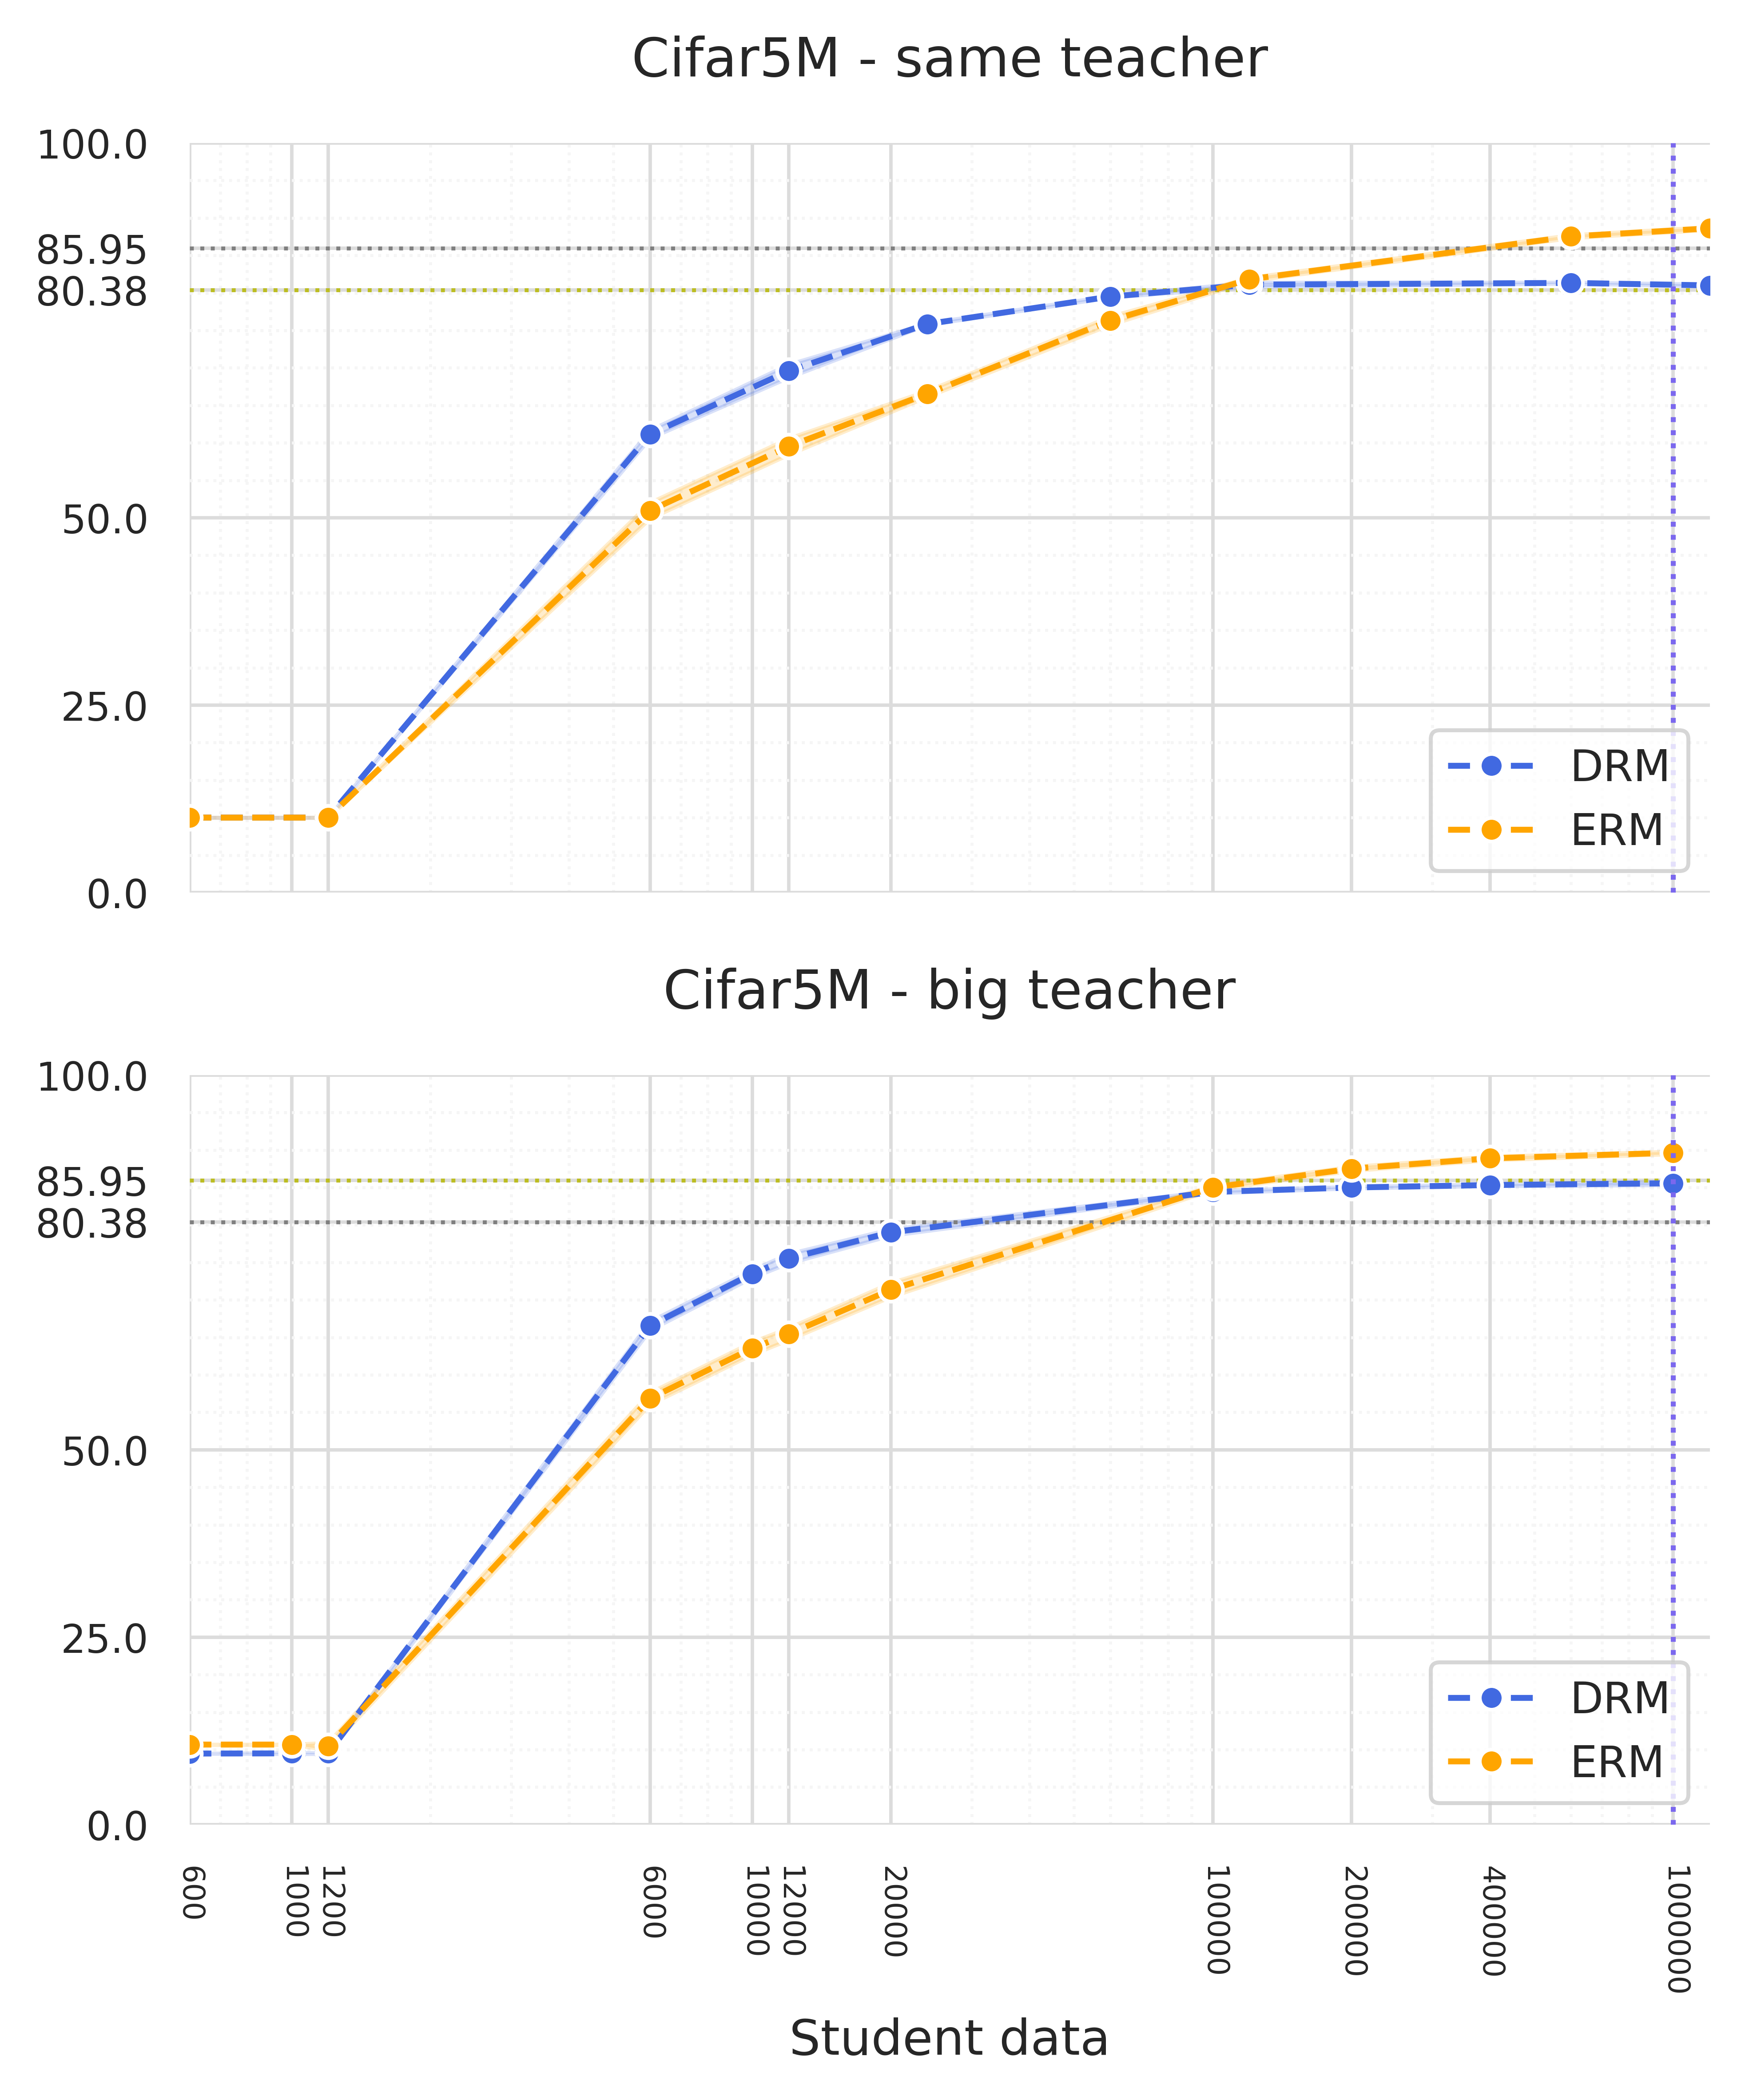

In [160]:
%matplotlib inline
sns.set_context("paper")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(2, 1,  figsize=(5,6), sharex=True, sharey=True, dpi=800)
    colors = ['royalblue','orange','dimgray']


    # ------------------------------- cifar 5m normal 

    ax[0].axhline(teacher_val_accuracy_sm, ls=':', color="tab:gray", linewidth=0.8)
    ax[0].axhline(teacher_val_accuracy, ls=':', color="tab:olive", linewidth=0.8)
    _df = working_df.loc[working_df['alpha']==0.0]
    sns.lineplot(data=_df, x="buffer_size", y="final_val_acc_S", errorbar="sd",
                 markers=True, marker='o', color=colors[0], ls='--',ax=ax[0], label="distil.val")
    _df = working_df.loc[working_df['alpha']==1.0]
    sns.lineplot(data=_df, x="buffer_size", y="final_val_acc_S", errorbar="sd",
                markers=True, marker='o', color=colors[1], ls='--', ax=ax[0], label="labels.val")
    

    #ax.axvline(100.0, ls='--', color='tab:green')
    # ax.axhline(76.034, ls='--', color=colors[2], label="a")
    # ax.axhline(teacher_train_accuracy, ls='-', color=colors[2], label="b")
    # # props = dict(boxstyle='square', facecolor='white', alpha=0.5)
    # ax.text(0.01, 0.9, 'teacher.val', transform=ax.transAxes, 
    #            fontsize=10, verticalalignment='top', bbox=props)
    ax[0].set_xscale('log')
    #ax.set_xscale('symlog',linthresh=10e-2)
    ax[0].set_xlim([600, 1000000])
    #ax[0].set_ylim([0.0,100.0])

    ax[0].tick_params(axis='both',  labelsize=9)
    ax[0].set_xticks(buffer_sizes)
    ax[0].set_xticklabels(buffer_sizes, fontsize=6)
    ax[0].tick_params(axis='x',  rotation=-90)

    yticks = [0.0, 25.0, 50.0, 75.0, teacher_val_accuracy, 100.0]
    plt.yticks(yticks)
    ax[0].set_yticklabels([0.0, 25.0, 50.0, 75.0, f'{teacher_val_accuracy}', 100.0], fontsize=8)

    ax[0].axvline(x=1000000, color='mediumslateblue', linewidth=1.0, linestyle=':')

    # #ax.text(10.0,0, "Local", color="white", bbox={'facecolor': 'tab:green', 'alpha': 0.5, 'pad': 10})
    # ax.set_ylim(-1,10000.0)


    ax[0].set_title(f"Cifar5M - same teacher", fontsize=11, y=1.05)
    ax[0].set_ylabel(r'', fontsize=11, x=-0.2)
    ax[0].set_xlabel(r'Student data', fontsize=10, y=+2)


    #ax[t].legend(title="Eigen-index", loc="upper left")
    # Shrink current axis's height by 10% on the bottom
    
    h, _ = ax[0].get_legend_handles_labels()
    ax[0].legend(h, ['DRM',
                  'ERM',
                  'teacher'], 
                title="", ncol=1, loc="lower right")


    # AESTHETICS control 
    ax[0].set_facecolor('white')
    [ax[0].spines[side].set_visible(False) for side in ax[0].spines]
    # major and minor grids
    ax[0].grid(which='major', color='gainsboro', linewidth=0.7)
    ax[0].grid(which='minor', color='whitesmoke', linestyle=':', linewidth=0.6)
    # Make the minor ticks and gridlines show.
    ax[0].minorticks_on()
    #ax.tick_params(which='minor', bottom=False, left=False)
    #fig.supxlabel(r' % of dataset used', fontsize=12, y=-0.1)

    #sns.despine()




    # ------------------------------- cifar 5m small 

    ax[1].axhline(teacher_val_accuracy, ls=':', color="tab:gray", linewidth=0.8)
    ax[1].axhline(teacher_val_accuracy_sm, ls=':', color="tab:olive", linewidth=0.8)
    _df = working_df_sm.loc[working_df_sm['alpha']==0.0]
    sns.lineplot(data=_df, x="buffer_size", y="final_val_acc_S", errorbar="sd",
                 markers=True, marker='o', color=colors[0], ls='--',ax=ax[1], label="distil.val")
    _df = working_df_sm.loc[working_df_sm['alpha']==1.0]
    sns.lineplot(data=_df, x="buffer_size", y="final_val_acc_S", errorbar="sd",
                markers=True, marker='o', color=colors[1], ls='--', ax=ax[1], label="labels.val")
    

    #ax.axvline(100.0, ls='--', color='tab:green')
    # ax.axhline(teacher_train_accuracy, ls='-', color=colors[2], label="b")
    # # props = dict(boxstyle='square', facecolor='white', alpha=0.5)
    # ax.text(0.01, 0.9, 'teacher.val', transform=ax.transAxes, 
    #            fontsize=10, verticalalignment='top', bbox=props)
    ax[1].set_xscale('log')
    #ax.set_xscale('symlog',linthresh=10e-2)
    #ax.set_xlim([0.1,0.4])
    ax[1].set_ylim([0.0,100.0])

    ax[1].tick_params(axis='both',  labelsize=9)
    ax[1].set_xticks(buffer_sizes_sm)
    ax[1].set_xticklabels(buffer_sizes_sm, fontsize=6)
    ax[1].tick_params(axis='x',  rotation=-90)

    yticks = [0.0, 25.0, 50.0, teacher_val_accuracy, teacher_val_accuracy_sm, 100.0]
    plt.yticks(yticks)
    ax[1].set_yticklabels([0.0, 25.0, 50.0, f'{teacher_val_accuracy}',f'{teacher_val_accuracy_sm}', 100.0], fontsize=8)

    ax[1].axvline(x=1000000, color='mediumslateblue', linewidth=1.0, linestyle=':')

    # #ax.text(10.0,0, "Local", color="white", bbox={'facecolor': 'tab:green', 'alpha': 0.5, 'pad': 10})
    # ax.set_ylim(-1,10000.0)


    ax[1].set_title(f"Cifar5M - big teacher", fontsize=11, y=1.05)
    ax[1].set_ylabel(r'', fontsize=11, x=-0.2)
    ax[1].set_xlabel(r'Student data', fontsize=10, y=+2)


    #ax[t].legend(title="Eigen-index", loc="upper left")
    # Shrink current axis's height by 10% on the bottom
    
    h, _ = ax[1].get_legend_handles_labels()
    ax[1].legend(h, ['DRM',
                  'ERM',
                  'teacher'], 
                title="", ncol=1, loc="lower right")


    # AESTHETICS control 
    ax[1].set_facecolor('white')
    [ax[1].spines[side].set_visible(False) for side in ax[1].spines]
    # major and minor grids
    ax[1].grid(which='major', color='gainsboro', linewidth=0.7)
    ax[1].grid(which='minor', color='whitesmoke', linestyle=':', linewidth=0.6)
    # Make the minor ticks and gridlines show.
    ax[1].minorticks_on()
    #ax.tick_params(which='minor', bottom=False, left=False)
    #fig.supxlabel(r' % of dataset used', fontsize=12, y=-0.1)


    #sns.despine()

    plt.tight_layout()


# Cifar 5M recurrent

In [249]:
logs_path = './logs/results/cifar5m/mnet/logs.txt'
results = []
with open(logs_path) as f:
    while line := f.readline():
        results.append(json.loads(line))

In [250]:
res_df = pd.DataFrame(results)
res_df

distributed   lr  checkpoints  pretrained  optim_wd  optim_adam   
0            no  0.1         True       False     0.001       False  \
1            no  0.1         True       False     0.001       False   
2            no  0.1         True       False     0.001       False   
3            no  0.1         True       False     0.001       False   
4            no  0.1         True       False     0.001       False   
..          ...  ...          ...         ...       ...         ...   
96           no  0.1         True       False     0.001       False   
97           no  0.1         True       False     0.001       False   
98           no  0.1         True       False     0.001       False   
99           no  0.1         True       False     0.001       False   
100          no  0.1         True       False     0.001       False   

     optim_mom  optim_warmup  optim_nesterov  optim_cosineanneal  ...   
0            0             5           False                True  ...  \
1            0             5           False                True  ...   
2            0             5           False                True  ...   
3            0             5           False                True  ...   
4            0             5           False                True  ...   
..         ...           ...             ...                 ...  ...   
96           0             5           False                True  ...   
97           0             5           False                True  ...   
98           0             5           False                True  ...   
99           0             5           False                True  ...   
100          0             5           False                True  ...   

     final_val_acc_S  final_train_agreement  final_val_agreement   
0              82.04              83.103333                79.19  \
1              71.77              87.058333                84.44   
2              76.98              77.181667                72.47   
3              71.53              87.015000                84.57   
4              71.91              87.883333                85.09   
..               ...                    ...                  ...   
96             75.79              87.391667                79.60   
97             75.93              87.095833                79.90   
98             65.91              81.241667                66.33   
99             66.42              81.575000                66.70   
100            66.69              81.487500                67.87   

     final_val_function_distance final_distance_teacher_student   
0                       0.224213                      99.827530  \
1                       0.137418                      92.841354   
2                       0.301173                      92.903893   
3                       0.134699                      92.821602   
4                       0.132162                      92.759621   
..                           ...                            ...   
96                      0.214165                     135.085800   
97                      0.211925                     134.979660   
98                      0.341851                     133.546890   
99                      0.339940                     133.632889   
100                     0.332657                     133.715759   

     recurrence_level buffer_size_p  generalization_gap  final_val_acc_S_p   
0                 NaN           2.0           -8.263333         124.472766  \
1                 NaN           1.0           -3.925000         108.890912   
2                 NaN           1.0          -14.481667         116.795630   
3                 NaN           1.0           -4.676667         108.526779   
4                 NaN           1.0           -4.843333         109.103323   
..                ...           ...                 ...                ...   
96                NaN           0.4           -6.805833         114.990138   
97                NaN       

In [248]:
res_df_rec.columns

RangeIndex(start=0, stop=1, step=1)

In [251]:
res_df_rec['buffer_size_p'] = res_df_rec['buffer_size']/60000
res_df_rec['generalization_gap'] = res_df_rec['final_val_acc_S']-res_df_rec['final_train_acc_S']
res_df_rec['final_val_acc_S_p'] = 100*res_df_rec['final_val_acc_S']/(teacher_val_accuracy)
res_df_rec['final_train_acc_S_p'] = 100*res_df_rec['final_train_acc_S']/(teacher_val_accuracy)
working_df_rec = res_df_rec
working_df_rec = working_df_rec.loc[working_df_rec['recurrence_level']==2] #HERE is the difference
working_df_rec = working_df_rec.loc[working_df_rec['MSE'].isin([np.nan, False]),:] # removing all the runs that didn't work 
working_df_rec

KeyError: 'buffer_size'

In [190]:
teacher_val_accuracy_rec = list(working_df_rec['final_val_acc_D'])[0]
#teacher_train_accuracy = 77.50
teacher_val_accuracy_rec

65.91

In [186]:
buffer_sizes = sorted(working_df_rec['buffer_size'].unique())
buffer_sizes

[600, 1200, 6000, 12000, 24000, 60000]

In [187]:
buffer_sizes_p = sorted(working_df_rec['buffer_size_p'].unique())
buffer_sizes_p

[0.01, 0.02, 0.1, 0.2, 0.4, 1.0]

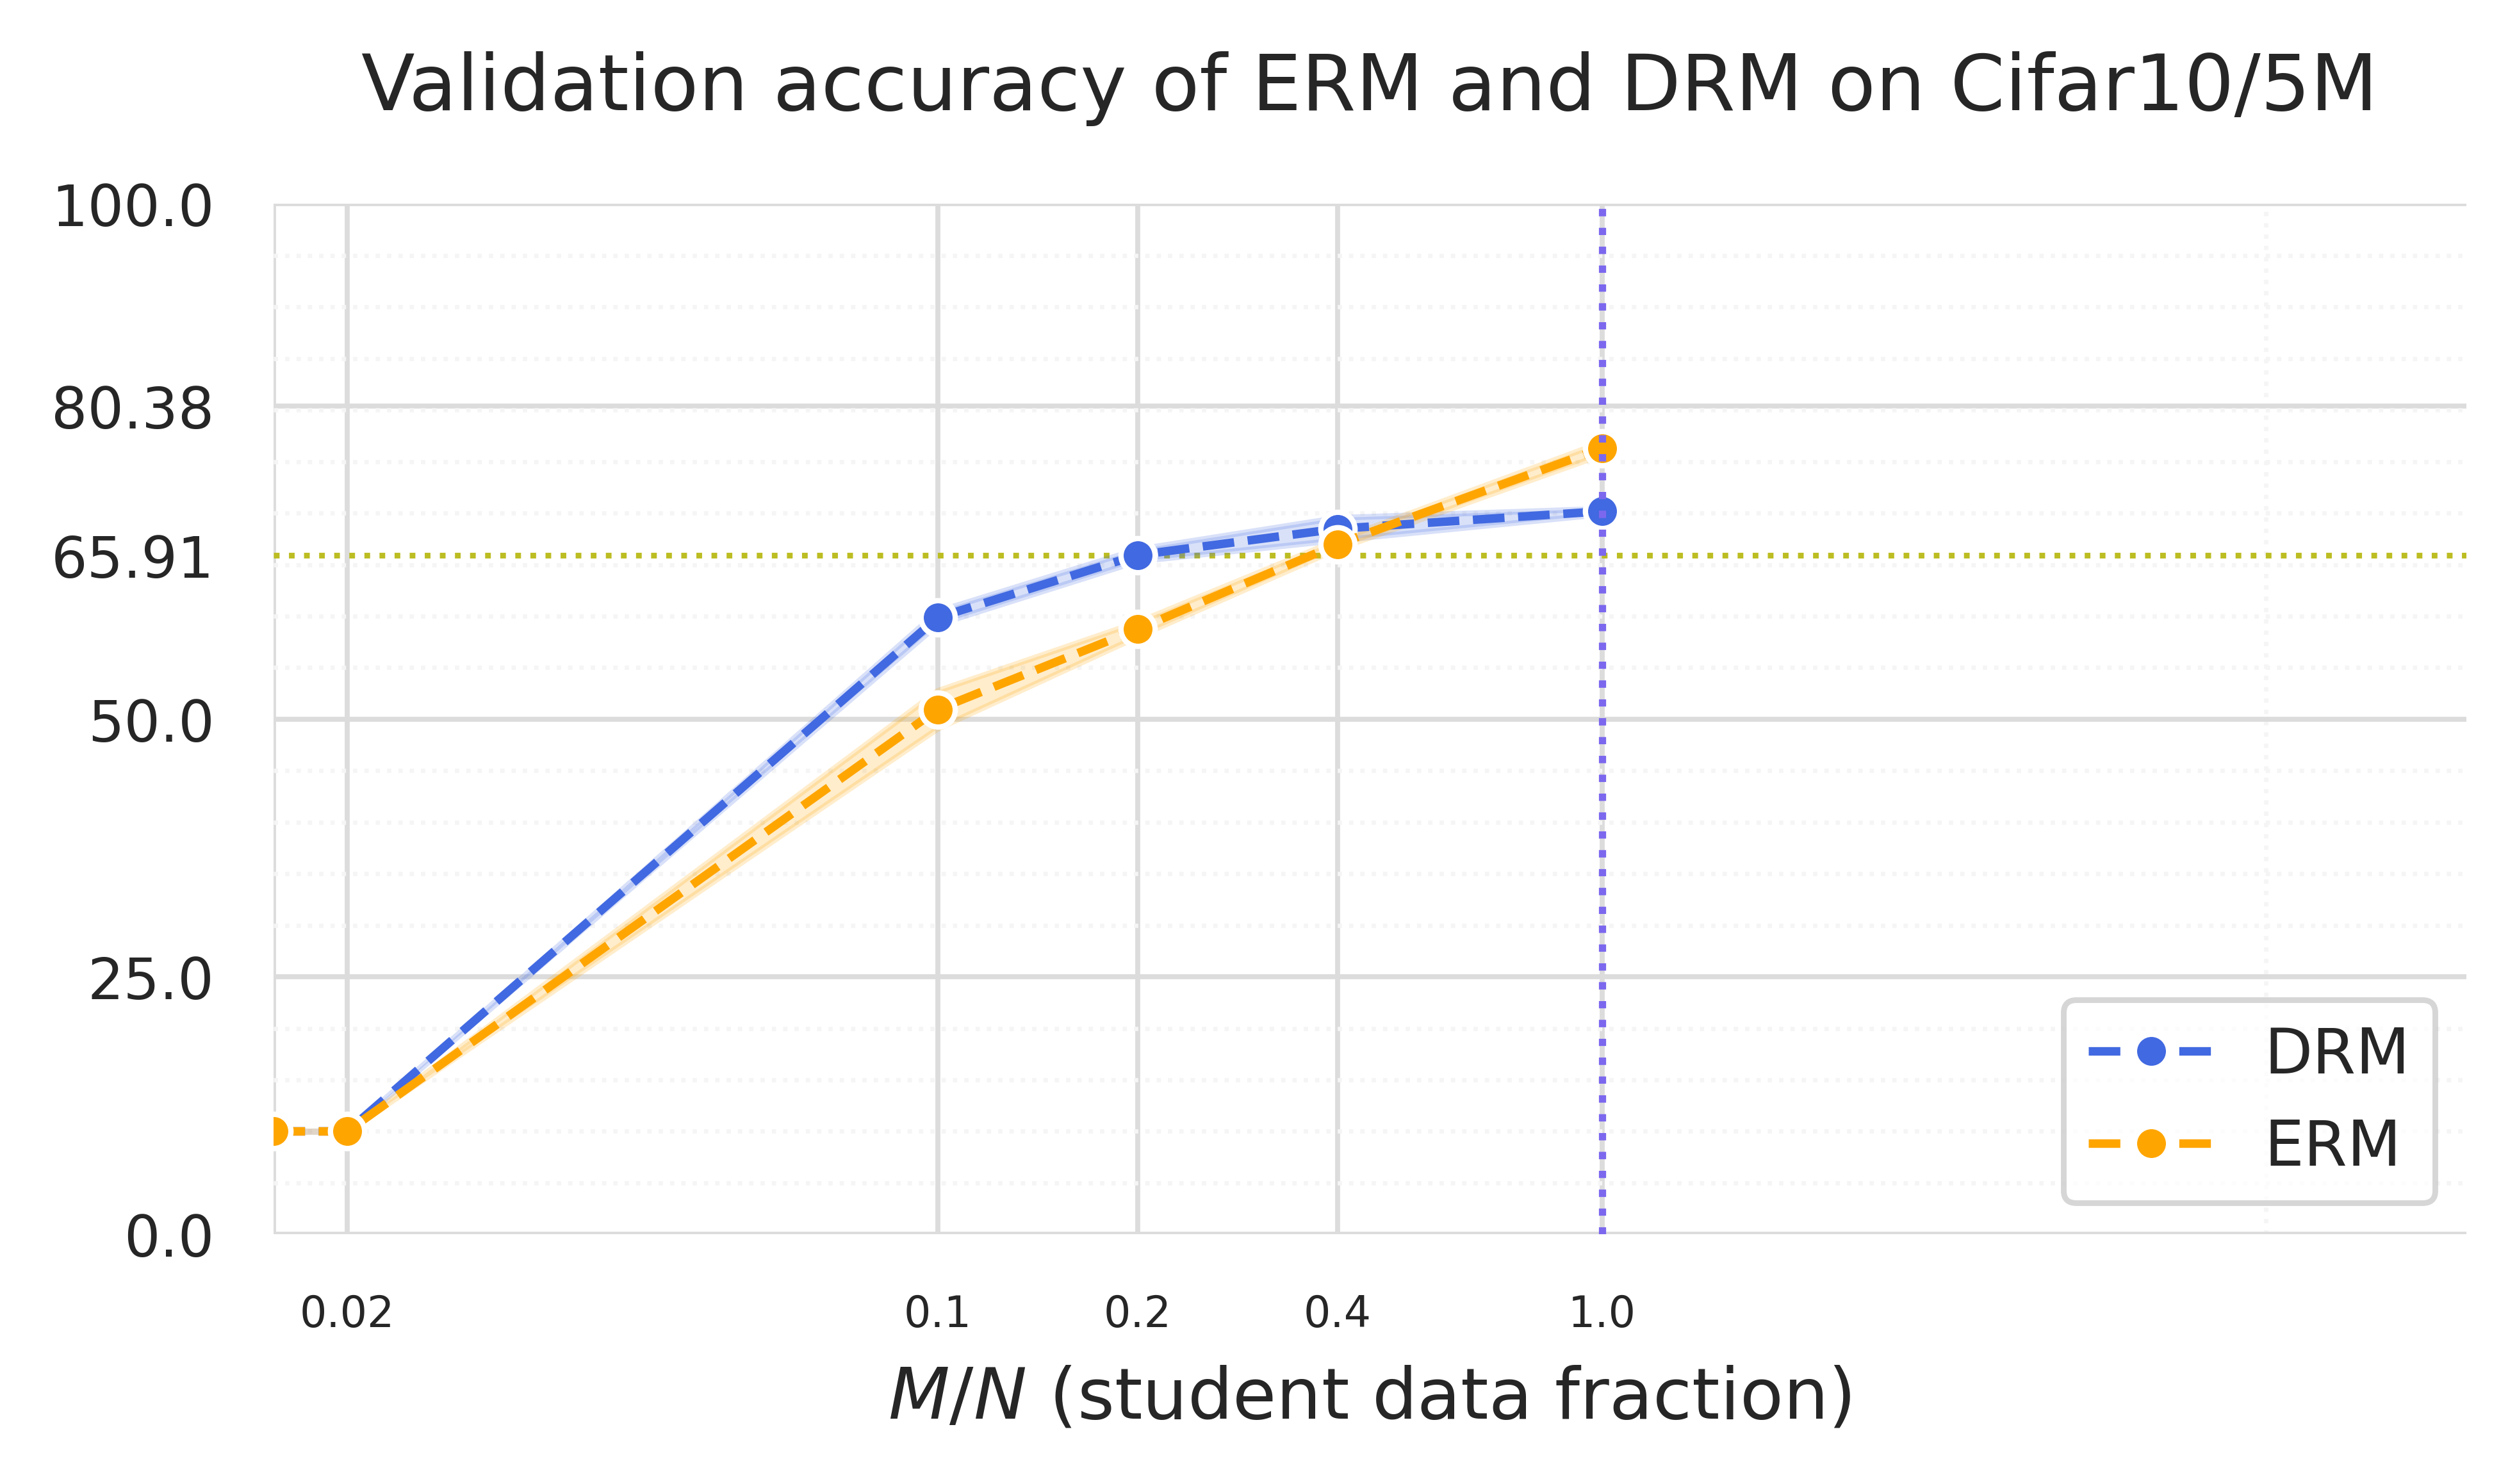

In [192]:
%matplotlib inline
sns.set_context("paper")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(5,3), sharey=True, dpi=800)
    colors = ['royalblue','orange','dimgray']


    _df = working_df_rec.loc[working_df_rec['alpha']==0.0]
    sns.lineplot(data=_df, x="buffer_size_p", y="final_val_acc_S", errorbar="sd",
                 markers=True, marker='o', color=colors[0], ls='--',ax=ax, label="distil.val")
    _df = working_df_rec.loc[working_df_rec['alpha']==1.0]
    sns.lineplot(data=_df, x="buffer_size_p", y="final_val_acc_S", errorbar="sd",
                markers=True, marker='o', color=colors[1], ls='--', ax=ax, label="labels.val")
    

    ax.axvline(1.0, color='mediumslateblue', linewidth=1.0, linestyle=':')
    # ax.axhline(76.034, ls='--', color=colors[2], label="a")
    # ax.axhline(teacher_train_accuracy, ls='-', color=colors[2], label="b")
    # # props = dict(boxstyle='square', facecolor='white', alpha=0.5)
    # ax.text(0.01, 0.9, 'teacher.val', transform=ax.transAxes, 
    #            fontsize=10, verticalalignment='top', bbox=props)
    #ax.set_xscale('log')
    ax.set_xscale('symlog',linthresh=10e-2)
    ax.set_xlim([0.1,20.])
    ax.set_ylim([0.0,100.0])

    ax.tick_params(axis='both',  labelsize=9)
    ax.set_xticks(buffer_sizes_p)
    ax.set_xticklabels(['']+[ f'{l}' for l in buffer_sizes_p[1:]], fontsize=6)
    ax.tick_params(axis='x',  rotation=0)

    yticks = [0.0, 25.0, 50.0,teacher_val_accuracy_rec, teacher_val_accuracy, 100.0]
    plt.yticks(yticks)
    ax.set_yticklabels([0.0, 25.0, 50.0, teacher_val_accuracy_rec, f'{teacher_val_accuracy}', 100.0], fontsize=8)

    ax.axvline(x=1.0, color='mediumslateblue', linewidth=1.0, linestyle=':')

    # #ax.text(10.0,0, "Local", color="white", bbox={'facecolor': 'tab:green', 'alpha': 0.5, 'pad': 10})
    # ax.set_ylim(-1,10000.0)


    ax.set_title(f"Validation accuracy of ERM and DRM on Cifar10/5M", fontsize=11, y=1.05)
    ax.set_ylabel(r'', fontsize=11, x=-0.2)
    ax.set_xlabel(r'$M/N$ (student data fraction)', fontsize=10, y=+1)


    #ax[t].legend(title="Eigen-index", loc="upper left")
    # Shrink current axis's height by 10% on the bottom
    
    h, _ = ax.get_legend_handles_labels()
    ax.legend(h, ['DRM',
                  'ERM',
                  'teacher'], 
                title="", ncol=1, loc="lower right")


    # AESTHETICS control 
    ax.set_facecolor('white')
    [ax.spines[side].set_visible(False) for side in ax.spines]
    # major and minor grids
    ax.grid(which='major', color='gainsboro', linewidth=0.7)
    ax.grid(which='minor', color='whitesmoke', linestyle=':', linewidth=0.6)
    # Make the minor ticks and gridlines show.
    ax.minorticks_on()
    #ax.tick_params(which='minor', bottom=False, left=False)
    #fig.supxlabel(r' % of dataset used', fontsize=12, y=-0.1)

    a = ax.get_ygridlines()
    b = a[3]
    b.set_color('tab:olive')
    b.set_linewidth(0.8)
    b.set_linestyle(':')
    #sns.despine()
    plt.tight_layout()


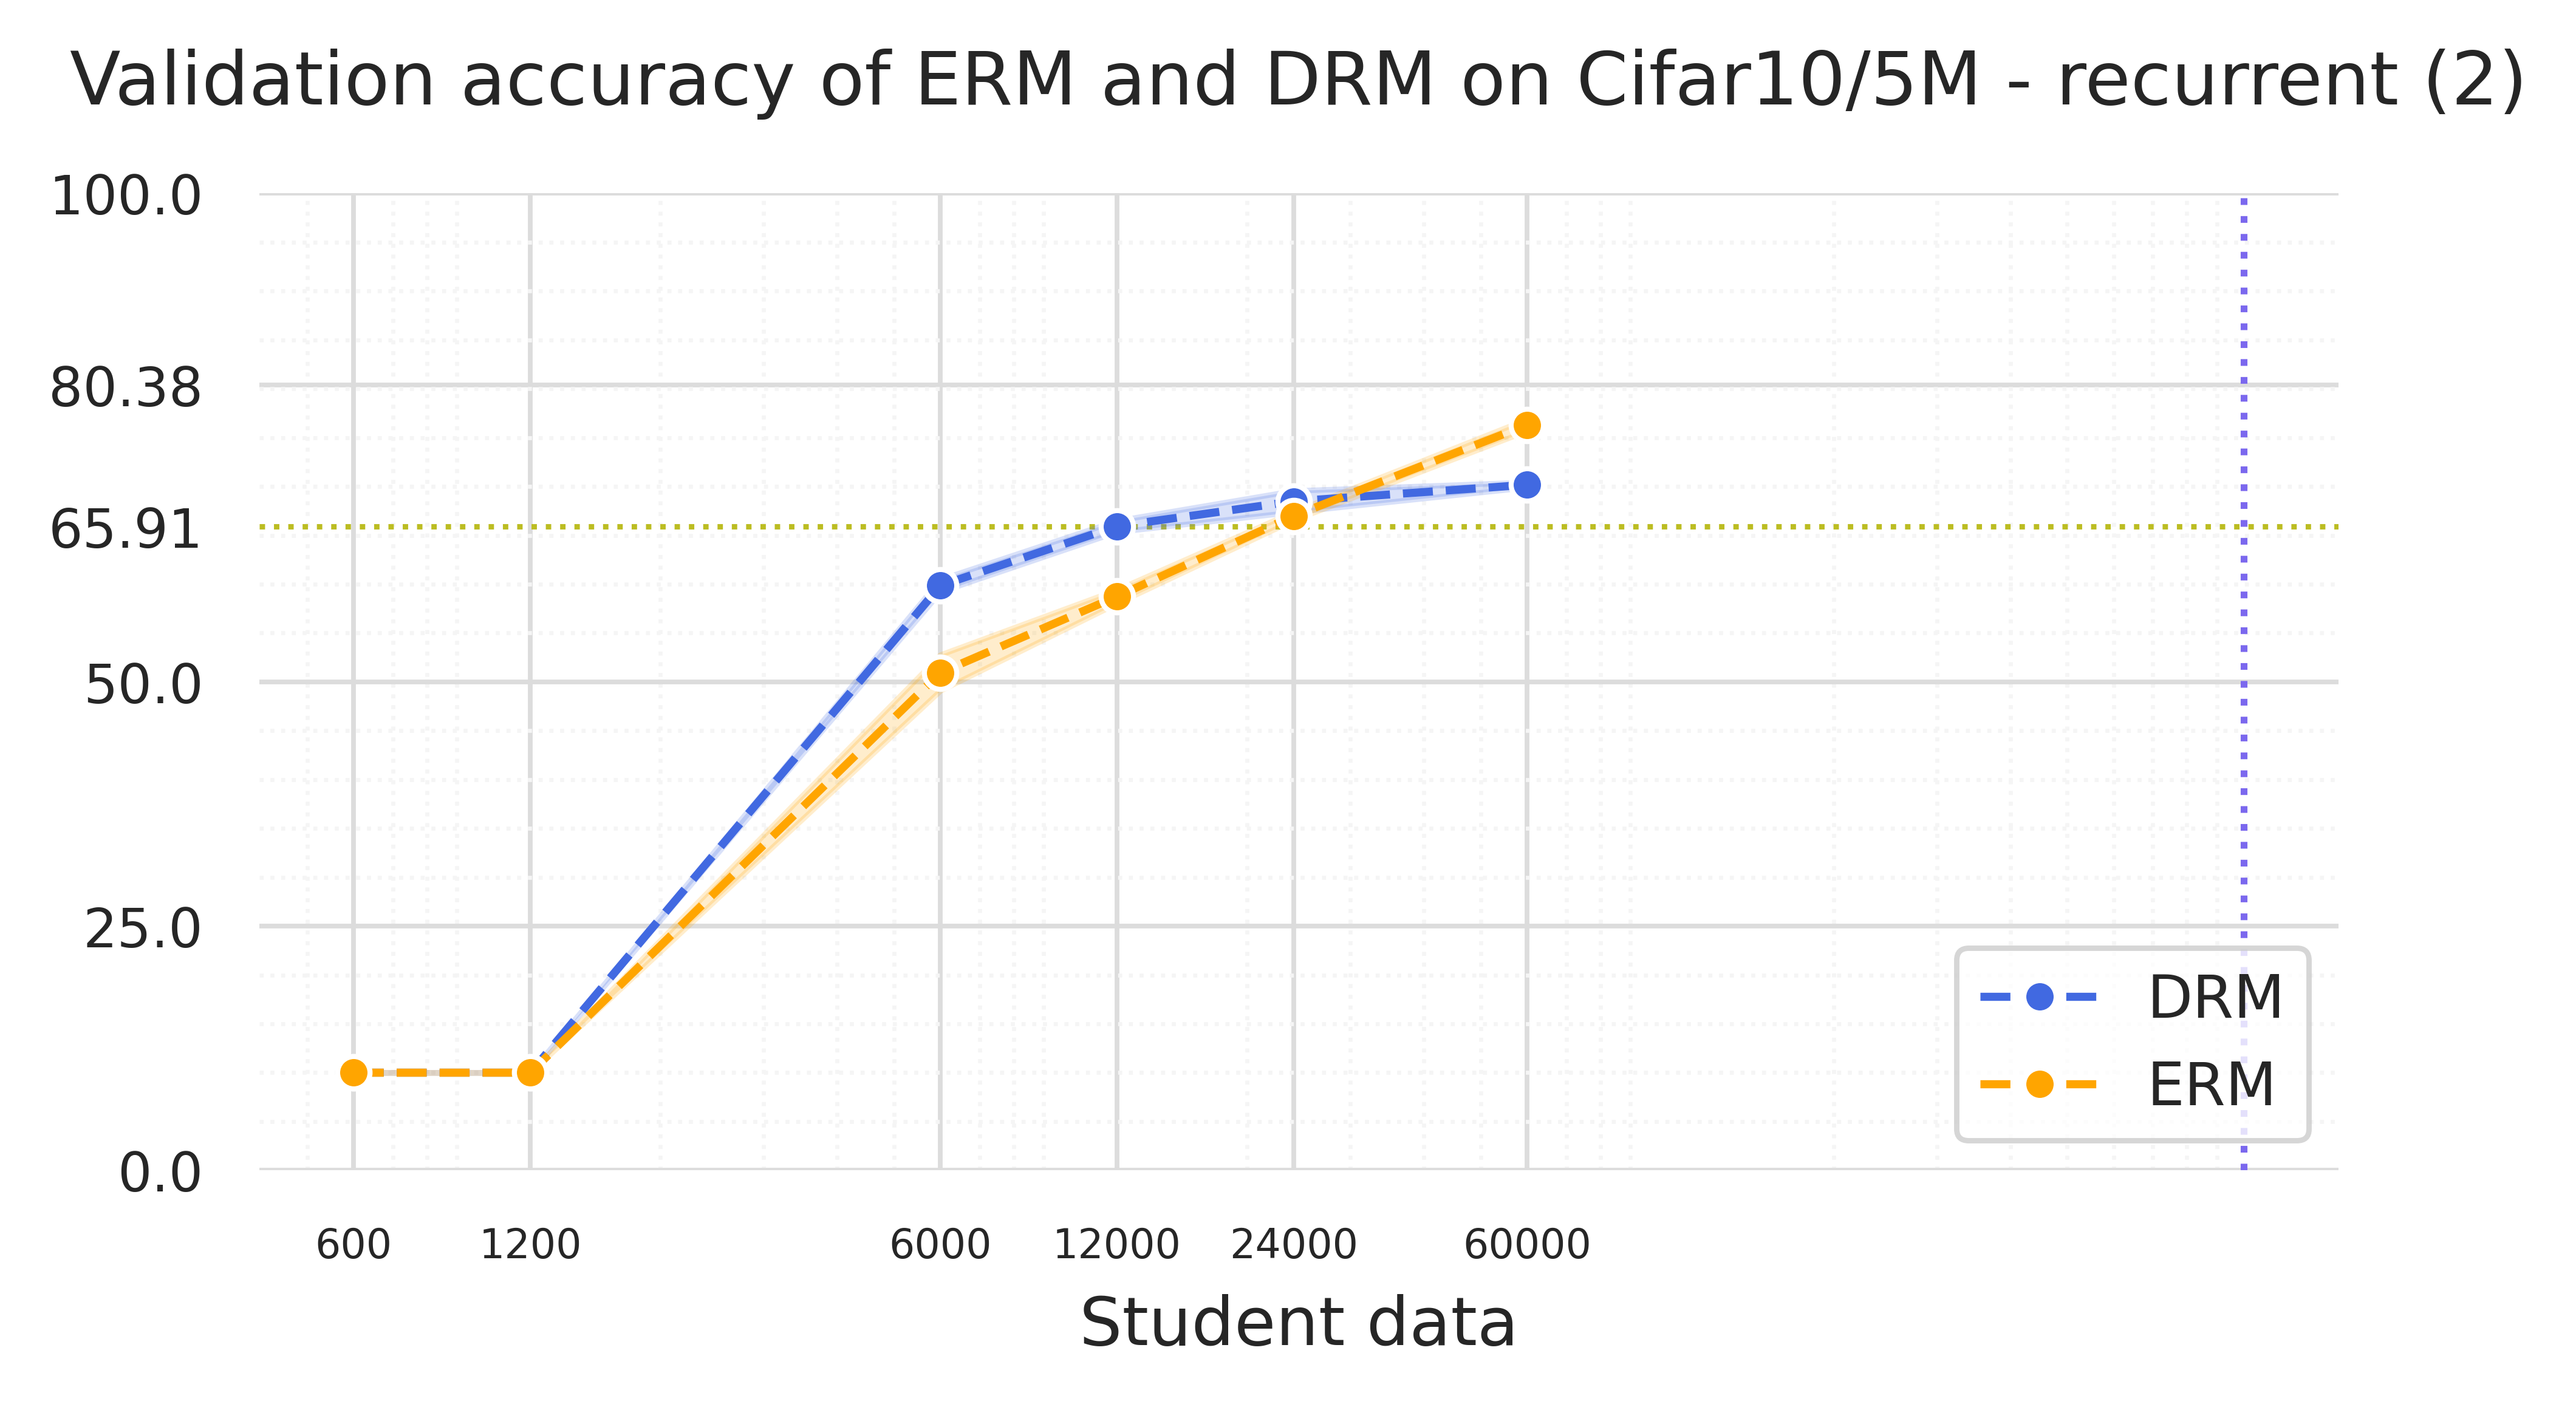

In [194]:
%matplotlib inline
sns.set_context("paper")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(5,3), sharey=True, dpi=800)
    colors = ['royalblue','orange','dimgray']


    _df = working_df_rec.loc[working_df_rec['alpha']==0.0]
    sns.lineplot(data=_df, x="buffer_size", y="final_val_acc_S", errorbar="sd",
                 markers=True, marker='o', color=colors[0], ls='--',ax=ax, label="distil.val")
    _df = working_df_rec.loc[working_df_rec['alpha']==1.0]
    sns.lineplot(data=_df, x="buffer_size", y="final_val_acc_S", errorbar="sd",
                markers=True, marker='o', color=colors[1], ls='--', ax=ax, label="labels.val")
    

    #ax.axvline(100.0, ls='--', color='tab:green')
    # ax.axhline(76.034, ls='--', color=colors[2], label="a")
    # ax.axhline(teacher_train_accuracy, ls='-', color=colors[2], label="b")
    # # props = dict(boxstyle='square', facecolor='white', alpha=0.5)
    # ax.text(0.01, 0.9, 'teacher.val', transform=ax.transAxes, 
    #            fontsize=10, verticalalignment='top', bbox=props)
    ax.set_xscale('log')
    #ax.set_xscale('symlog',linthresh=10e-2)
    #ax.set_xlim([0.1,0.4])
    ax.set_ylim([0.0,100.0])

    ax.tick_params(axis='both',  labelsize=9)
    ax.set_xticks(buffer_sizes)
    ax.set_xticklabels(buffer_sizes, fontsize=6)
    ax.tick_params(axis='x',  rotation=0)

    yticks = [0.0, 25.0, 50.0, teacher_val_accuracy_rec, teacher_val_accuracy, 100.0]
    plt.yticks(yticks)
    ax.set_yticklabels([0.0, 25.0, 50.0, teacher_val_accuracy_rec, teacher_val_accuracy, 100.0], fontsize=8)

    ax.axvline(x=1000000, color='mediumslateblue', linewidth=1.0, linestyle=':')

    # #ax.text(10.0,0, "Local", color="white", bbox={'facecolor': 'tab:green', 'alpha': 0.5, 'pad': 10})
    # ax.set_ylim(-1,10000.0)


    ax.set_title(f"Validation accuracy of ERM and DRM on Cifar10/5M - recurrent (2)", fontsize=11, y=1.05)
    ax.set_ylabel(r'', fontsize=11, x=-0.2)
    ax.set_xlabel(r'Student data', fontsize=10, y=+1)


    #ax[t].legend(title="Eigen-index", loc="upper left")
    # Shrink current axis's height by 10% on the bottom
    
    h, _ = ax.get_legend_handles_labels()
    ax.legend(h, ['DRM',
                  'ERM',
                  'teacher'], 
                title="", ncol=1, loc="lower right")


    # AESTHETICS control 
    ax.set_facecolor('white')
    [ax.spines[side].set_visible(False) for side in ax.spines]
    # major and minor grids
    ax.grid(which='major', color='gainsboro', linewidth=0.7)
    ax.grid(which='minor', color='whitesmoke', linestyle=':', linewidth=0.6)
    # Make the minor ticks and gridlines show.
    ax.minorticks_on()
    #ax.tick_params(which='minor', bottom=False, left=False)
    #fig.supxlabel(r' % of dataset used', fontsize=12, y=-0.1)

    a = ax.get_ygridlines()
    b = a[3]
    b.set_color('tab:olive')
    b.set_linewidth(0.8)
    b.set_linestyle(':')
    #sns.despine()
    plt.tight_layout()
